In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, SecondLocator, DateFormatter

import plotly.graph_objects as go
import plotly.express as px

import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import scipy

import inference
import learning
import torch

import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02
from aeon.analysis.utils import visits, distancetravelled

In [2]:
!ls /ceph/aeon

aeon			 aeon_transfer.log  rmhzbm0  test2
aeon_transfer_final.log  db_dumps	    test


In [3]:
# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

# Ensure root exists
if not np.all([path.exists() for path in root]):
    print("Cannot find root paths. Check path names or connection.")

In [4]:
Exp02Summary = api.load(root, exp02.Metadata).metadata[0].toDict()
Patch_Pos = [device['Regions']['ArrayOfPoint'] for device in Exp02Summary['Devices'] if device['Name'].startswith('ActivityPatch')]

In [5]:
subject_events = api.load(root, exp02.ExperimentalMetadata.SubjectState)
sessions = visits(subject_events[subject_events.id.str.startswith("BAA-")])

display(sessions)

id  weight_enter  weight_exit                         enter  \
0   BAA-1100700         26.40        28.10 2022-02-23 14:21:25.550300121   
1   BAA-1100700         25.50        28.45 2022-03-02 13:47:43.875840187   
2   BAA-1100700         24.55        24.55 2022-03-04 14:00:01.818980217   
3   BAA-1100700         24.55        28.27 2022-03-04 14:04:16.610499859   
4   BAA-1100700         26.30        26.30 2022-03-15 12:40:36.282139778   
5   BAA-1100700         27.60        28.80 2022-03-16 15:06:37.790820122   
6   BAA-1100700         25.50        28.50 2022-03-17 15:56:35.478690147   
7   BAA-1100700         24.30        26.80 2022-03-23 14:47:58.253819942   
8   BAA-1100699         26.75        29.00 2022-03-29 13:11:37.277699947   
9   BAA-1100701         27.00        26.70 2022-04-04 13:59:13.352029800   
10  BAA-1100701         26.70        30.60 2022-04-04 15:54:07.945059776   
11  BAA-1100699         29.00        28.20 2022-04-20 11:51:24.997630119   
12  BAA-1100700         29.20        29.30 2022-04-29 09:37:08.806660175   
13  BAA-1100701         33.00        32.20 2022-04-29 09:37:50.754849911   
14  BAA-1100702         27.00        28.90 2022-05-03 11:08:12.660739899   
15  BAA-1100703         30.30        29.50 2022-05-25 08:59:51.050459862   
16  BAA-1101818         26.20        26.70 2022-06-21 10:27:42.615139961   
17  BAA-1101819         25.40        26.40 2022-06-21 13:28:10.593659878   
18  BAA-1101818         24.50        28.40 2022-06-22 07:55:41.628640175   
19  BAA-1101819         24.90        26.90 2022-06-22 07:55:57.696700096   
20  BAA-1101818         26.40        28.00 2022-06-23 08:39:04.261089801   
21  BAA-1101818         28.00        26.40 2022-06-23 11:24:11.156350136   
22  BAA-1101819         25.60        27.50 2022-06-23 11:24:23.876420021   
23  BAA-1101818         26.90        27.80 2022-06-24 09:32:37.183360100   
24  BAA-1101823         27.90        27.90 2022-07-14 12:53:15.740799904   
25  BAA-1101821         25.00        26.00 2022-07-15 13:14:40.239679813   
26  BAA-1101819         25.70        27.10 2022-07-19 10:37:08.422299862   
27  BAA-1101818         25.70        28.20 2022-07-19 13:04:16.233019829   
28  BAA-1101818         26.70        29.50 2022-08-15 10:25:01.651199818   
29  BAA-1101819         27.50        30.00 2022-08-15 13:11:23.791259766   
30  BAA-1101818         26.50        30.10 2022-08-16 09:25:53.963200092   
31  BAA-1101819         27.30        30.50 2022-08-16 12:38:11.445700169   
32  BAA-1102227         24.10        24.07 2022-08-24 12:57:30.558179855   
33  BAA-1102223         30.30        29.10 2022-09-26 10:37:39.908189774   
34  BAA-1102224         28.80        27.90 2022-10-03 11:04:29.183259964   

                            exit                   duration  
0  2022-02-25 16:00:50.076419830  2 days 01:39:24.526119709  
1  2022-03-02 18:14:47.459969997  0 days 04:27:03.584129810  
2  2022-03-04 14:00:49.259260178  0 days 00:00:47.440279961  
3  2022-03-04 19:24:41.778140068  0 days 05:20:25.167640209  
4  2022-03-15 15:56:55.801119804  0 days 03:16:19.518980026  
5  2022-03-16 16:44:50.910079956  0 days 01:38:13.119259834  
6  2022-03-17 17:41:48.763070107  0 days 01:45:13.284379960  
7  2022-03-24 14:08:54.449150085  0 days 23:20:56.195330143  
8  2022-04-04 09:16:51.086110115  5 days 20:05:13.808410168  
9  2022-04-04 15:19:41.652349949  0 days 01:20:28.300320149  
10 2022-04-08 16:34:36.183650017  4 days 00:40:28.238590241  
11 2022-04-28 10:02:56.655809879  7 days 22:11:31.658179760  
12 2022-04-29 12:40:39.900259972  0 days 03:03:31.093599797  
13 2022-04-29 12:40:51.436289787  0 days 03:03:00.681439876  
14 2022-05-12 09:21:42.411650181  8 days 22:13:29.750910282  
15 2022-06-06 07:55:37.501309872 11 days 22:55:46.450850010  
16 2022-06-21 13:15:50.564740181  0 days 02:48:07.949600220  
17 2022-06-21 16:34:29.241280079  0 days 03:06:18.647620201  
18 2022-06-22 13:29:04.050240040  0 days 05:33:22.421599865  
19 2022-06-22 13:29:13.682270050  0 

# Choose Valid Sessions

In [45]:
sessions_ = sessions.iloc[[4,8,10,11,14,16,17,20,23,24,25,26,28,29,30,31]]
display(sessions_)

id  weight_enter  weight_exit                         enter  \
4   BAA-1100700         26.30         26.3 2022-03-15 12:40:36.282139778   
8   BAA-1100699         26.75         29.0 2022-03-29 13:11:37.277699947   
10  BAA-1100701         26.70         30.6 2022-04-04 15:54:07.945059776   
11  BAA-1100699         29.00         28.2 2022-04-20 11:51:24.997630119   
14  BAA-1100702         27.00         28.9 2022-05-03 11:08:12.660739899   
16  BAA-1101818         26.20         26.7 2022-06-21 10:27:42.615139961   
17  BAA-1101819         25.40         26.4 2022-06-21 13:28:10.593659878   
20  BAA-1101818         26.40         28.0 2022-06-23 08:39:04.261089801   
23  BAA-1101818         26.90         27.8 2022-06-24 09:32:37.183360100   
24  BAA-1101823         27.90         27.9 2022-07-14 12:53:15.740799904   
25  BAA-1101821         25.00         26.0 2022-07-15 13:14:40.239679813   
26  BAA-1101819         25.70         27.1 2022-07-19 10:37:08.422299862   
28  BAA-1101818         26.70         29.5 2022-08-15 10:25:01.651199818   
29  BAA-1101819         27.50         30.0 2022-08-15 13:11:23.791259766   
30  BAA-1101818         26.50         30.1 2022-08-16 09:25:53.963200092   
31  BAA-1101819         27.30         30.5 2022-08-16 12:38:11.445700169   

                            exit                  duration  
4  2022-03-15 15:56:55.801119804 0 days 03:16:19.518980026  
8  2022-04-04 09:16:51.086110115 5 days 20:05:13.808410168  
10 2022-04-08 16:34:36.183650017 4 days 00:40:28.238590241  
11 2022-04-28 10:02:56.655809879 7 days 22:11:31.658179760  
14 2022-05-12 09:21:42.411650181 8 days 22:13:29.750910282  
16 2022-06-21 13:15:50.564740181 0 days 02:48:07.949600220  
17 2022-06-21 16:34:29.241280079 0 days 03:06:18.647620201  
20 2022-06-23 11:14:46.121759892 0 days 02:35:41.860670091  
23 2022-06-24 12:29:54.365859985 0 days 02:57:17.182499885  
24 2022-07-14 16:35:05.846270084 0 days 03:41:50.105470180  
25 2022-07-15 15:47:44.568860054 0 days 02:33:04.329180241  
26 2022-07-19 16:04:43.376220226 0 days 05:27:34.953920364  
28 2022-08-15 13:04:50.849309921 0 days 02:39:49.198110103  
29 2022-08-15 16:10:27.350080013 0 days 02:59:03.558820247  
30 2022-08-16 12:34:02.296770096 0 days 03:08:08.333570004  
31 2022-08-16 15:41:41.197569847 0 days 03:03:29.751869678

## Short Sessions

In [7]:
short_sessions = sessions.iloc[[4,16,17,20,23,24,25,26,28,29,30,31]]

In [8]:
"""for session in list(short_sessions.itertuples()):
    ID = session.id
    start, end = session.enter, session.exit 
    start_, end_ = start.floor('H'), end.ceil('H')

    duration_in_days = session.duration.total_seconds() / (60**2)
    title = str(ID) + "  " + str(session.duration)
    print(title)
    print(start)
    
    pstate1 = api.load(root, exp02.Patch1.DepletionState, start=start, end=end)
    pstate2 = api.load(root, exp02.Patch2.DepletionState, start=start, end=end)

    pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)
    pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)

    weight= api.load(root, exp02.Nest.WeightSubject, start=start, end=end)
    
    times = pd.date_range(start=start_, end=end_, freq='H')
    CR = []
    for time in times:
        if time.hour >= 20 or time.hour <= 7: CR.append(0)
        else: CR.append(1)

    fig, axs = plt.subplots(6, 1, figsize=(int(duration_in_days*10), 5), sharex=True)

    axs[0].scatter(pstate2.index, pstate2['threshold'].to_numpy(), color = 'green')
    axs[0].set_xticks([]) 
    axs[0].set_yticks([]) 
    axs[0].set_facecolor('white') 
    axs[0].set_ylabel('S2', fontsize = 14)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].set_xlim(start_, end_)
    axs[0].set_yticks([50,100])
    axs[0].set_ylim(0, 110)

    for pellet in pellets_patch2.itertuples():
        forage_time = pellet.Index
        axs[1].axvline(pd.Timestamp(forage_time), color='green', linewidth=1)
    axs[1].set_xticks([]) 
    axs[1].set_yticks([]) 
    axs[1].set_facecolor('white') 
    axs[1].set_ylabel('P2', fontsize = 14)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].set_xlim(start_, end_)

    for pellet in pellets_patch1.itertuples():
        forage_time = pellet.Index
        axs[2].axvline(pd.Timestamp(forage_time), color='brown', linewidth=1)
    axs[2].set_yticks([])  
    axs[2].set_facecolor('white')  
    axs[2].set_ylabel('P1', fontsize = 14)
    axs[2].spines['top'].set_visible(False)
    axs[2].spines['right'].set_visible(False)
    axs[2].set_xlim(start_, end_)
    
    axs[3].scatter(pstate1.index, pstate1['threshold'].to_numpy(), color = 'brown')
    axs[3].set_xticks([]) 
    axs[3].set_yticks([]) 
    axs[3].set_facecolor('white') 
    axs[3].set_ylabel('S1', fontsize = 14)
    axs[3].spines['top'].set_visible(False)
    axs[3].spines['right'].set_visible(False)
    axs[3].set_xlim(start_, end_)
    axs[3].set_yticks([50,100])
    axs[3].set_ylim(0, 110)
    
    axs[4].scatter(weight.index, weight['value'].to_numpy(), color = 'black')
    axs[4].set_xticks([]) 
    axs[4].set_yticks([]) 
    axs[4].set_facecolor('white') 
    axs[4].set_ylabel('W', fontsize = 14)
    axs[4].spines['top'].set_visible(False)
    axs[4].spines['right'].set_visible(False)
    axs[4].set_xlim(start_, end_)
    
    
    axs[5].plot(times, CR, color = 'blue')
    axs[5].set_ylabel('CR', fontsize = 14)
    axs[5].spines['top'].set_visible(False)
    axs[5].spines['right'].set_visible(False)
    axs[5].set_xlim(start_, end_)
    axs[5].set_ylim(-0.1, 1.1)    
    axs[5].set_xticks(times)
    time_format = matplotlib.dates.DateFormatter('%H')
    axs[5].xaxis.set_major_formatter(time_format)
    axs[5].tick_params(axis='x', labelsize = 12)

    #axs[0].set_title(title)
    plt.tight_layout()
    plt.show()"""

'for session in list(short_sessions.itertuples()):\n    ID = session.id\n    start, end = session.enter, session.exit \n    start_, end_ = start.floor(\'H\'), end.ceil(\'H\')\n\n    duration_in_days = session.duration.total_seconds() / (60**2)\n    title = str(ID) + "  " + str(session.duration)\n    print(title)\n    print(start)\n    \n    pstate1 = api.load(root, exp02.Patch1.DepletionState, start=start, end=end)\n    pstate2 = api.load(root, exp02.Patch2.DepletionState, start=start, end=end)\n\n    pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)\n    pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)\n\n    weight= api.load(root, exp02.Nest.WeightSubject, start=start, end=end)\n    \n    times = pd.date_range(start=start_, end=end_, freq=\'H\')\n    CR = []\n    for time in times:\n        if time.hour >= 20 or time.hour <= 7: CR.append(0)\n        else: CR.append(1)\n\n    fig, axs = plt.subplots(6, 1, figsize=(int(du

## Long Sessions

In [8]:
long_sessions = sessions.iloc[[8, 10, 11, 14]]

In [10]:
"""for session in list(long_sessions.itertuples()):
    ID = session.id
    start, end = session.enter, session.exit 
    start_, end_ = start.ceil('H'), end.ceil('H')

    duration_in_days = session.duration.total_seconds() / (60**2*24)
    title = str(ID) + "  " + str(session.duration)
    print(title)
    
    pstate1 = api.load(root, exp02.Patch1.DepletionState, start=start, end=end)
    pstate2 = api.load(root, exp02.Patch2.DepletionState, start=start, end=end)

    pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)
    pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)

    weight= api.load(root, exp02.Nest.WeightSubject, start=start, end=end)
    
    times = pd.date_range(start=start_, end=end_, freq='H')
    CR = []
    for time in times:
        if time.hour >= 20 or time.hour <= 7: CR.append(0)
        else: CR.append(1)

    fig, axs = plt.subplots(6, 1, figsize=(int(duration_in_days*10), 5), sharex=True)

    axs[0].scatter(pstate2.index, pstate2['threshold'].to_numpy(), color = 'green')
    axs[0].set_xticks([]) 
    axs[0].set_yticks([]) 
    axs[0].set_facecolor('white') 
    axs[0].set_ylabel('S2', fontsize = 14)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].set_xlim(start_, end_)
    axs[0].set_yticks([50,100])
    axs[0].set_ylim(0, 110)

    for pellet in pellets_patch2.itertuples():
        forage_time = pellet.Index
        axs[1].axvline(pd.Timestamp(forage_time), color='green', linewidth=1)
    axs[1].set_xticks([]) 
    axs[1].set_yticks([]) 
    axs[1].set_facecolor('white') 
    axs[1].set_ylabel('P2', fontsize = 14)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].set_xlim(start_, end_)

    for pellet in pellets_patch1.itertuples():
        forage_time = pellet.Index
        axs[2].axvline(pd.Timestamp(forage_time), color='brown', linewidth=1)
    axs[2].set_yticks([])  
    axs[2].set_facecolor('white')  
    axs[2].set_ylabel('P1', fontsize = 14)
    axs[2].spines['top'].set_visible(False)
    axs[2].spines['right'].set_visible(False)
    axs[2].set_xlim(start_, end_)
    
    axs[3].scatter(pstate1.index, pstate1['threshold'].to_numpy(), color = 'brown')
    axs[3].set_xticks([]) 
    axs[3].set_yticks([]) 
    axs[3].set_facecolor('white') 
    axs[3].set_ylabel('S1', fontsize = 14)
    axs[3].spines['top'].set_visible(False)
    axs[3].spines['right'].set_visible(False)
    axs[3].set_xlim(start_, end_)
    axs[3].set_yticks([50,100])
    axs[3].set_ylim(0, 110)
    
    axs[4].scatter(weight.index, weight['value'].to_numpy(), color = 'black')
    axs[4].set_xticks([]) 
    axs[4].set_yticks([]) 
    axs[4].set_facecolor('white') 
    axs[4].set_ylabel('W', fontsize = 14)
    axs[4].spines['top'].set_visible(False)
    axs[4].spines['right'].set_visible(False)       
    axs[4].set_xlim(start_, end_)
    
    
    axs[5].plot(times, CR, color = 'blue')
    axs[5].set_ylabel('CR', fontsize = 14)
    axs[5].spines['top'].set_visible(False)
    axs[5].spines['right'].set_visible(False)
    axs[5].set_xlim(start_, end_)
    axs[5].set_ylim(-0.1, 1.1)    
    axs[5].set_xticks(times)
    time_format = matplotlib.dates.DateFormatter('%H')
    axs[5].xaxis.set_major_formatter(time_format)
    axs[5].tick_params(axis='x', labelsize = 12)

    #axs[0].set_title(title)
    plt.tight_layout()
    plt.show()"""

'for session in list(long_sessions.itertuples()):\n    ID = session.id\n    start, end = session.enter, session.exit \n    start_, end_ = start.ceil(\'H\'), end.ceil(\'H\')\n\n    duration_in_days = session.duration.total_seconds() / (60**2*24)\n    title = str(ID) + "  " + str(session.duration)\n    print(title)\n    \n    pstate1 = api.load(root, exp02.Patch1.DepletionState, start=start, end=end)\n    pstate2 = api.load(root, exp02.Patch2.DepletionState, start=start, end=end)\n\n    pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)\n    pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)\n\n    weight= api.load(root, exp02.Nest.WeightSubject, start=start, end=end)\n    \n    times = pd.date_range(start=start_, end=end_, freq=\'H\')\n    CR = []\n    for time in times:\n        if time.hour >= 20 or time.hour <= 7: CR.append(0)\n        else: CR.append(1)\n\n    fig, axs = plt.subplots(6, 1, figsize=(int(duration_in_days*10

# Set Filtering Parameters - CWPA

In [42]:
def LDSParameters(pos_0, dt):
    pos_x0, pos_y0 = pos_0[0], pos_0[1]
    vel_x0, vel_y0 = 0.0, 0.0
    acc_x0, acc_y0 = 0.0, 0.0

    sigma_a = 0.5
    sqrt_diag_V0_value = 1e-3

    m0 = np.array([pos_x0, vel_x0, acc_x0, pos_y0, vel_y0, acc_y0], dtype=np.double)
    V0 = np.diag(np.ones(len(m0))*sqrt_diag_V0_value**2)


    B = np.array([[1, dt, dt**2/2, 0, 0, 0],
                [0, 1, dt, 0, 0, 0],
                [0, 0, 1, 0, 0, 0],
                [0, 0, 0, 1, dt, dt**2/2],
                [0, 0, 0, 0, 1, dt],
                [0, 0, 0, 0, 0, 1]],
                dtype=np.double)


    Qe = np.array([[dt**5/20, dt**4/8, dt**3/6, 0, 0, 0],
                [dt**4/8, dt**3/3,  dt**2/2, 0, 0, 0],
                [dt**3/6, dt**2/2,  dt,      0, 0, 0],
                [0, 0, 0,                    dt**5/20, dt**4/8, dt**3/6],
                [0, 0, 0,                    dt**4/8, dt**3/3,  dt**2/2],
                [0, 0, 0,                    dt**3/6, dt**2/2,  dt]],
                dtype=np.double)
    Q = sigma_a**2 * Qe


    # Observation 
    sigma_x = 1
    sigma_y = 1

    Z = np.array([[1, 0, 0, 0, 0, 0],
                [0, 0, 0, 1, 0, 0]],
                dtype=np.double)
    R = np.diag([sigma_x**2, sigma_y**2])
    
    return B, Q, m0, V0, Z, R

# Filter Each Session

## Short Sessions

In [10]:
def PlotSmoothData(date_times, smoothRes, title):
    smoothed_mean_x = smoothRes['xnN'][0][0]
    smoothed_mean_y = smoothRes['xnN'][3][0]

    trace_x = go.Scatter(x=date_times, y=smoothed_mean_x, mode='lines', name='X position', line=dict(color='blue'))
    trace_y = go.Scatter(x=date_times, y=smoothed_mean_y, mode='lines', name='Y position', line=dict(color='red'))

    fig = go.Figure()
    fig.add_trace(trace_x)
    fig.add_trace(trace_y)

    fig.update_layout(
        title='Position Over Time',
        xaxis=dict(
            title='Time',
            showgrid=True,
            gridcolor='LightGrey',
            tickformat='%H',  # Format time as hours
            tickvals=date_times,  # Set tick values to date_times
            tickangle=45,  # Optional: rotate labels for better readability
        ),
        yaxis=dict(
            title='Position',
            showgrid=True,
            gridcolor='LightGrey'
        ),
        legend=dict(x=1, y=1),
        showlegend=True,
        plot_bgcolor='white',
        margin=dict(l=40, r=40, t=40, b=40)  # Adjust margins to fit your needs
    )

    fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)

    path = title + '.html'
    fig.write_html(path)

In [11]:
def DeleteNan(obs):
    x_index = len(obs[0])-1
    for i in range(len(obs[0])-1, 1, -1):
        if np.isnan(obs[0][i]): x_index=i
        else: break
        
    y_index = len(obs[0])-1
    for i in range(len(obs[1])-1, 1, -1):
        if np.isnan(obs[1][i]): y_index=i
        else: break
    
    return obs[:,0:min(x_index, y_index)]

In [14]:
'''FILTERRES_Short = []
SMOOTHRES_Short = []
for session in list(short_sessions.itertuples()):
    start, end = session.enter, session.exit
    
    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
    obs = np.transpose(mouse_pos[["x", "y"]].to_numpy())
    obs = DeleteNan(obs)
    
    date_times = pd.to_datetime(mouse_pos.index)
    dt = (date_times[1]-date_times[0]).total_seconds()
    
    B, Q, m0, V0, Z, R = LDSParameters([obs[0,0],obs[1,0]], dt)

    filterRes = inference.filterLDS_SS_withMissingValues_np(
        y=obs, B=B, Q=Q, m0=m0, V0=V0, Z=Z, R=R)

    FILTERRES_Short.append(filterRes)
    
    smoothRes = inference.smoothLDS_SS( 
        B=B, xnn=filterRes["xnn"], Vnn=filterRes["Vnn"],
        xnn1=filterRes["xnn1"], Vnn1=filterRes["Vnn1"], m0=m0, V0=V0)
    
    SMOOTHRES_Short.append(smoothRes)

np.savez("Filter_Short.npz", np.array(FILTERRES_Short))
np.savez("Smooth_Short.npz", np.array(SMOOTHRES_Short))'''

'FILTERRES_Short = []\nSMOOTHRES_Short = []\nfor session in list(short_sessions.itertuples()):\n    start, end = session.enter, session.exit\n    \n    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)\n    obs = np.transpose(mouse_pos[["x", "y"]].to_numpy())\n    obs = DeleteNan(obs)\n    \n    date_times = pd.to_datetime(mouse_pos.index)\n    dt = (date_times[1]-date_times[0]).total_seconds()\n    \n    B, Q, m0, V0, Z, R = LDSParameters([obs[0,0],obs[1,0]], dt)\n\n    filterRes = inference.filterLDS_SS_withMissingValues_np(\n        y=obs, B=B, Q=Q, m0=m0, V0=V0, Z=Z, R=R)\n\n    FILTERRES_Short.append(filterRes)\n    \n    smoothRes = inference.smoothLDS_SS( \n        B=B, xnn=filterRes["xnn"], Vnn=filterRes["Vnn"],\n        xnn1=filterRes["xnn1"], Vnn1=filterRes["Vnn1"], m0=m0, V0=V0)\n    \n    SMOOTHRES_Short.append(smoothRes)\n\nnp.savez("Filter_Short.npz", np.array(FILTERRES_Short))\nnp.savez("Smooth_Short.npz", np.array(SMOOTHRES_Short))'

/tmp/ipykernel_4014/12794899.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_pos_['smoothed_position_x'] = pd.Series(smoothRes['xnN'][0][0], index=mouse_pos_.index)
/tmp/ipykernel_4014/12794899.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_pos_['smoothed_position_y'] = pd.Series(smoothRes['xnN'][3][0], index=mouse_pos_.index)
/tmp/ipykernel_4014/12794899.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

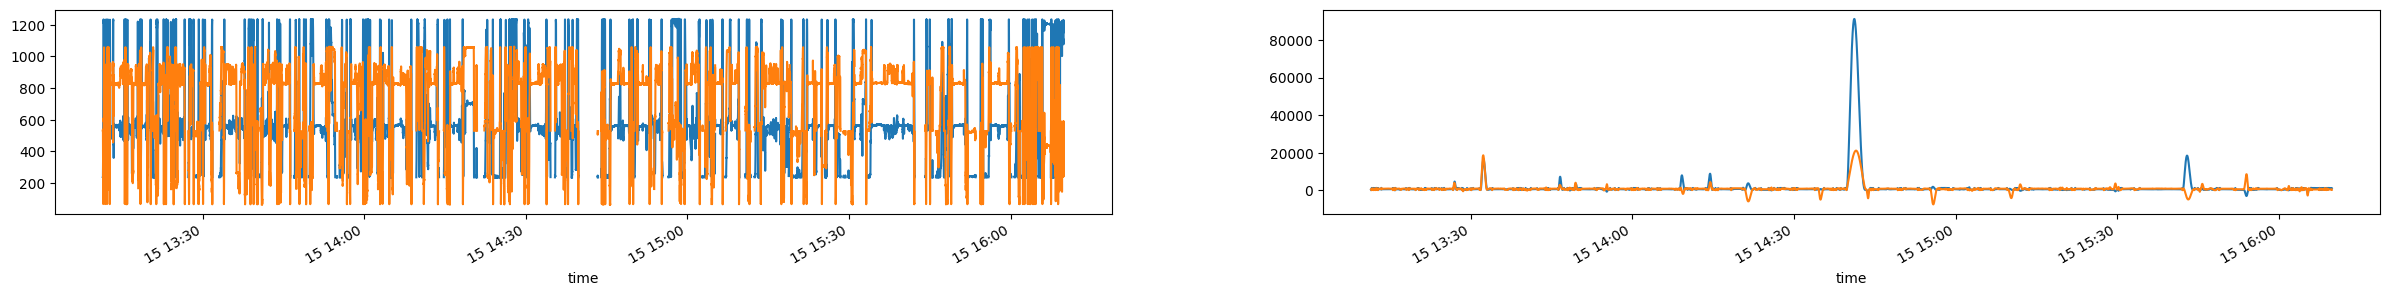

In [43]:
start, end = pd.Timestamp('2022-08-15 13:11:23.791259766'), pd.Timestamp('2022-08-15 16:10:27.350080013')
        
mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)

temp_df = mouse_pos.dropna(subset=['x', 'y'])

first_valid_index = temp_df.index[0]
last_valid_index = temp_df.index[-1]

mouse_pos_ = mouse_pos.loc[first_valid_index:last_valid_index]


obs = np.transpose(mouse_pos_[["x", "y"]].to_numpy())

        
date_times = pd.to_datetime(mouse_pos_.index)
dt = (date_times[1]-date_times[0]).total_seconds()
        
B, Q, m0, V0, Z, R = LDSParameters([obs[0,0],obs[1,0]], dt)

filterRes = inference.filterLDS_SS_withMissingValues_np(
            y=obs, B=B, Q=Q, m0=m0, V0=V0, Z=Z, R=R)
        
smoothRes = inference.smoothLDS_SS( 
            B=B, xnn=filterRes["xnn"], Vnn=filterRes["Vnn"],
            xnn1=filterRes["xnn1"], Vnn1=filterRes["Vnn1"], m0=m0, V0=V0)

mouse_pos_['smoothed_position_x'] = pd.Series(smoothRes['xnN'][0][0], index=mouse_pos_.index)
mouse_pos_['smoothed_position_y'] = pd.Series(smoothRes['xnN'][3][0], index=mouse_pos_.index)
mouse_pos_['smoothed_velocity_x'] = pd.Series(smoothRes['xnN'][1][0], index=mouse_pos_.index)
mouse_pos_['smoothed_velocity_y'] = pd.Series(smoothRes['xnN'][4][0], index=mouse_pos_.index)
mouse_pos_['smoothed_acce_x'] = pd.Series(smoothRes['xnN'][2][0], index=mouse_pos_.index)
mouse_pos_['smoothed_acce_y'] = pd.Series(smoothRes['xnN'][5][0], index=mouse_pos_.index)

fig, axs = plt.subplots(1,2, figsize = (30,3))
mouse_pos_.x.plot(ax = axs[0])
mouse_pos_.y.plot(ax = axs[0])
mouse_pos_.smoothed_position_x.plot(ax = axs[1])
mouse_pos_.smoothed_position_y.plot(ax = axs[1])
plt.show()

In [47]:
mouse_pos_

x           y     angle      major  \
time                                                                          
2022-08-15 13:11:30.051296234   237.836426  531.666687  0.615629  21.392565   
2022-08-15 13:11:30.071328163   238.111542  532.057739  0.692832  21.362879   
2022-08-15 13:11:30.091296196   238.459061  532.976929  0.748926  22.551018   
2022-08-15 13:11:30.111328125   238.480743  533.356445  0.811811  23.558784   
2022-08-15 13:11:30.131296158   238.517136  533.782959  0.831264  23.872244   
...                                    ...         ...       ...        ...   
2022-08-15 16:09:50.689951897          NaN         NaN       NaN   0.000000   
2022-08-15 16:09:50.709919930  1169.290771  360.710236 -0.404999  23.353966   
2022-08-15 16:09:50.729951859  1173.738647  349.587494 -0.423652  26.019552   
2022-08-15 16:09:50.749919891  1176.221436  339.704376 -0.302875  21.719299   
2022-08-15 16:09:50.769951820  1177.113647  330.519196  0.977775  13.071411   

                                   minor   area   id  smoothed_position_x  \
time                                                                        
2022-08-15 13:11:30.051296234   7.034308  108.0  0.0           237.836566   
2022-08-15 13:11:30.071328163   7.562149  127.0  0.0           237.837688   
2022-08-15 13:11:30.091296196   7.623689  144.5  0.0           237.840712   
2022-08-15 13:11:30.111328125   7.588374  151.5  0.0           237.846569   
2022-08-15 13:11:30.131296158   7.825123  160.5  0.0           237.856180   
...                                  ...    ...  ...                  ...   
2022-08-15 16:09:50.689951897   0.000000    0.0  0.0          1153.423253   
2022-08-15 16:09:50.709919930  10.669894  164.5  0.0          1152.201342   
2022-08-15 16:09:50.729951859  13.682992  301.0  0.0          1150.956360   
2022-08-15 16:09:50.749919891  13.908017  269.5  0.0          1149.688309   
2022-08-15 16:09:50.769951820   8.064083  108.5  0.0          1148.397188   

                               smoothed_position_y  smoothed_velocity_x  \
time                                                                      
2022-08-15 13:11:30.051296234           531.663876             0.024246   
2022-08-15 13:11:30.071328163           531.659162             0.095663   
2022-08-15 13:11:30.091296196           531.646627             0.213947   
2022-08-15 13:11:30.111328125           531.622560             0.378494   
2022-08-15 13:11:30.131296158           531.583386             0.588696   
...                                            ...                  ...   
2022-08-15 16:09:50.689951897           297.509464           -60.425167   
2022-08-15 16:09:50.709919930           292.827399           -61.576884   
2022-08-15 16:09:50.729951859           288.107673           -62.728593   
2022-08-15 16:09:50.749919891           283.350286           -63.880299   
2022-08-15 16:09:50.769951820           278.555238           -65.032004   

                               smoothed_velocity_y  smoothed_acce_x  \
time                                                                  
2022-08-15 13:11:30.051296234            -0.103561         2.385416   
2022-08-15 13:11:30.071328163            -0.399131         4.740227   
2022-08-15 13:11:30.091296196            -0.883331         7.064859   
2022-08-15 13:11:30.111328125            -1.549388         9.359261   
2022-08-15 13:11:30.131296158            -2.390618        11.623379   
...                                            ...              ...   
2022-08-15 16:09:50.689951897          -232.800869       -57.497059   
2022-08-15 16:09:50.709919930          -234.681021       -57.496476   
2022-08-15 16:09:50.729951859          -236.561158       -57.496223   
2022-08-15 16:09:50.749919891          -238.441289       -57.496147   
2022-08-15 16:09:50.769951820          -240.321418       -57.496137   

                               smoothed_acce_y  
time                                            
2022-08-15 13

## Long Sessions

# Kinematic Data Summary - Short

In [12]:
FILTERRES_Short = np.load('Filter_Short.npz', allow_pickle=True)['arr_0']
SMOOTHRES_Short = np.load('Smooth_Short.npz', allow_pickle=True)['arr_0']

## Position

In [17]:
def Extend(len_df, array):
    len_array = len(array)
    extended_array = np.full(len_df, np.nan)
    extended_array[:len_array] = array
    return extended_array

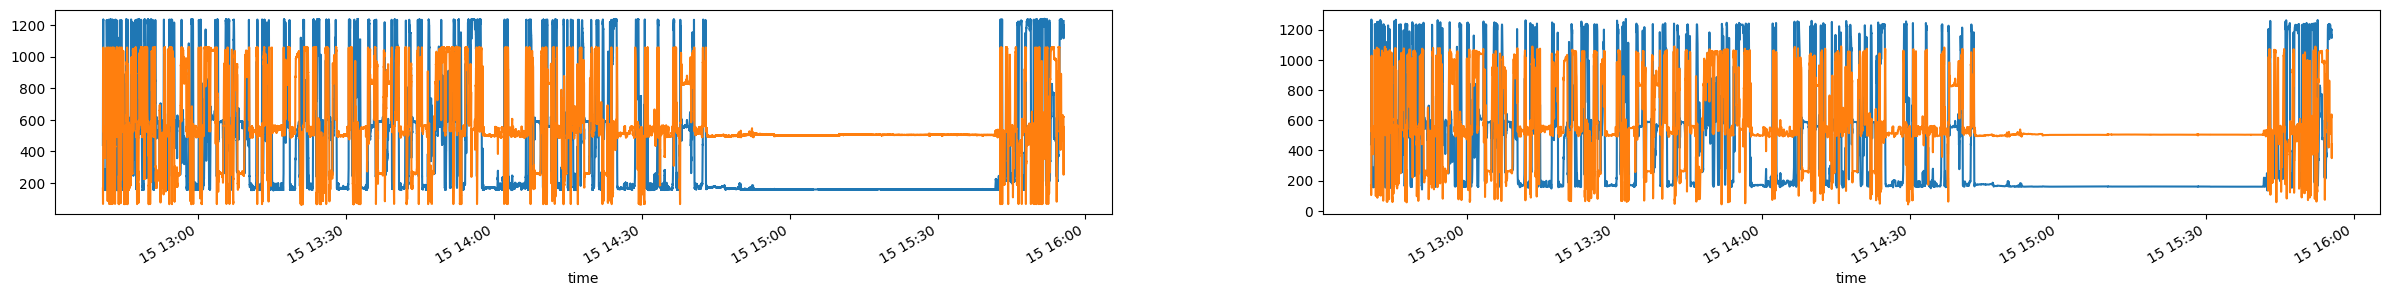

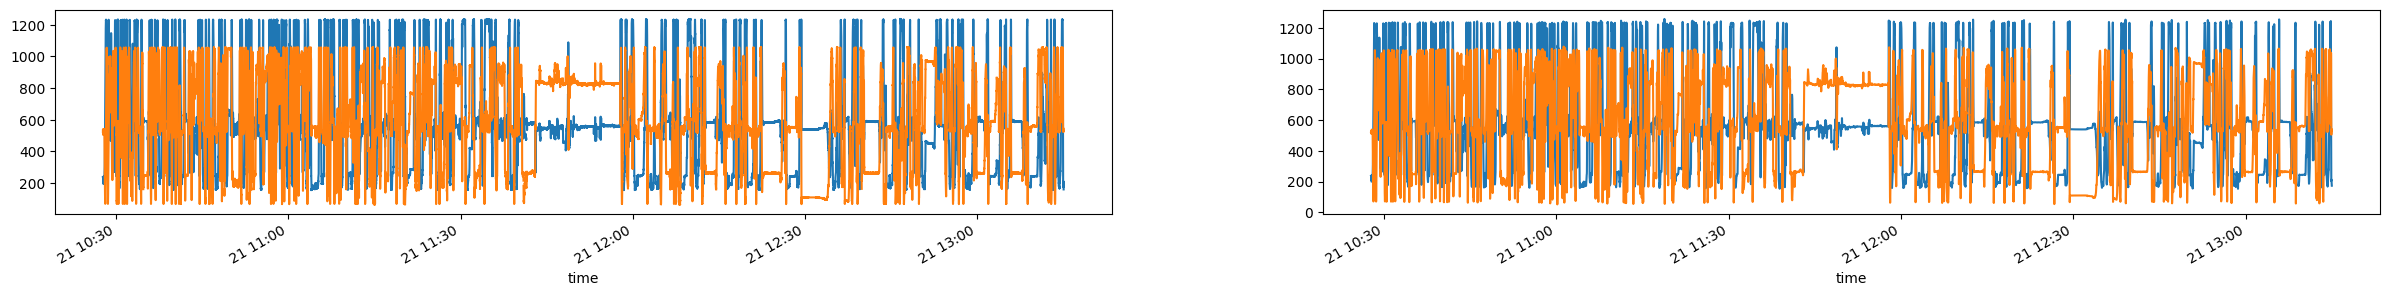

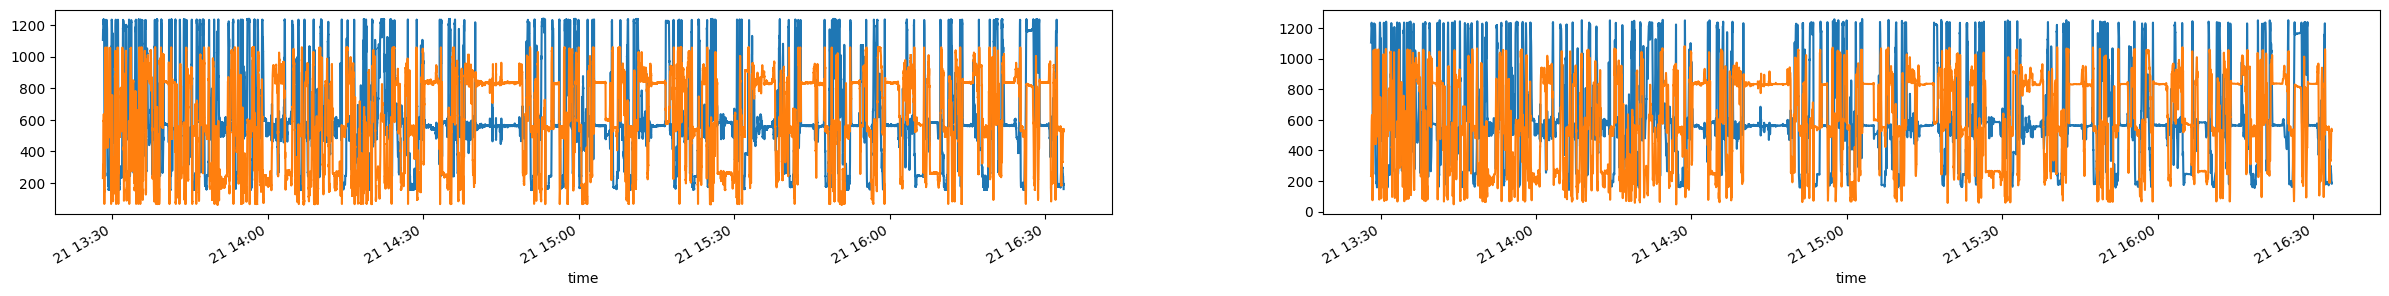

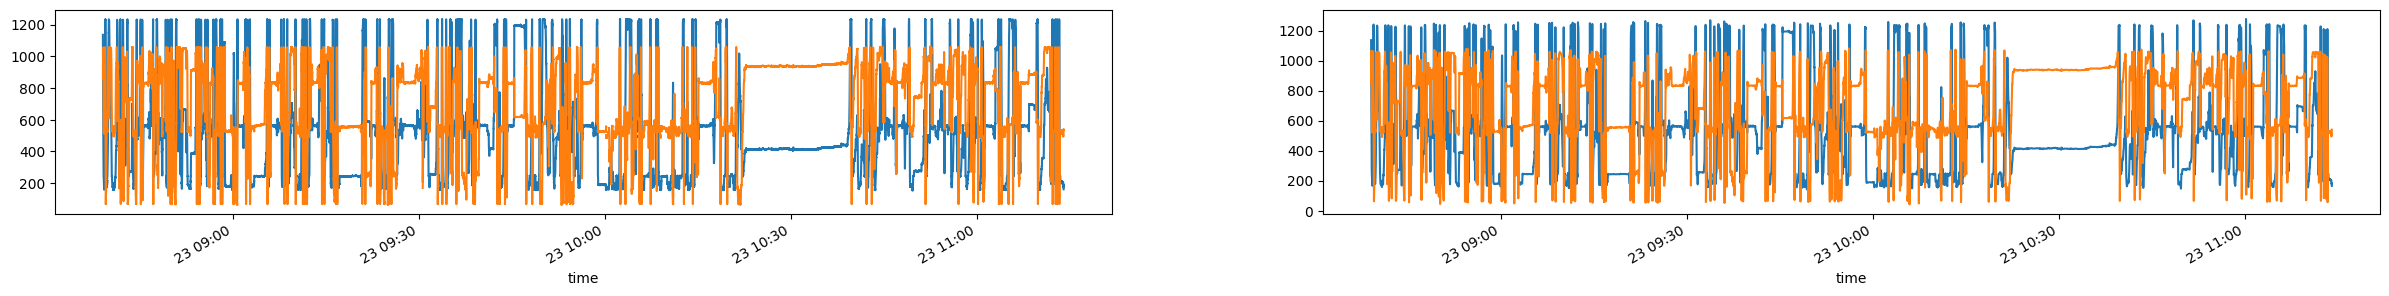

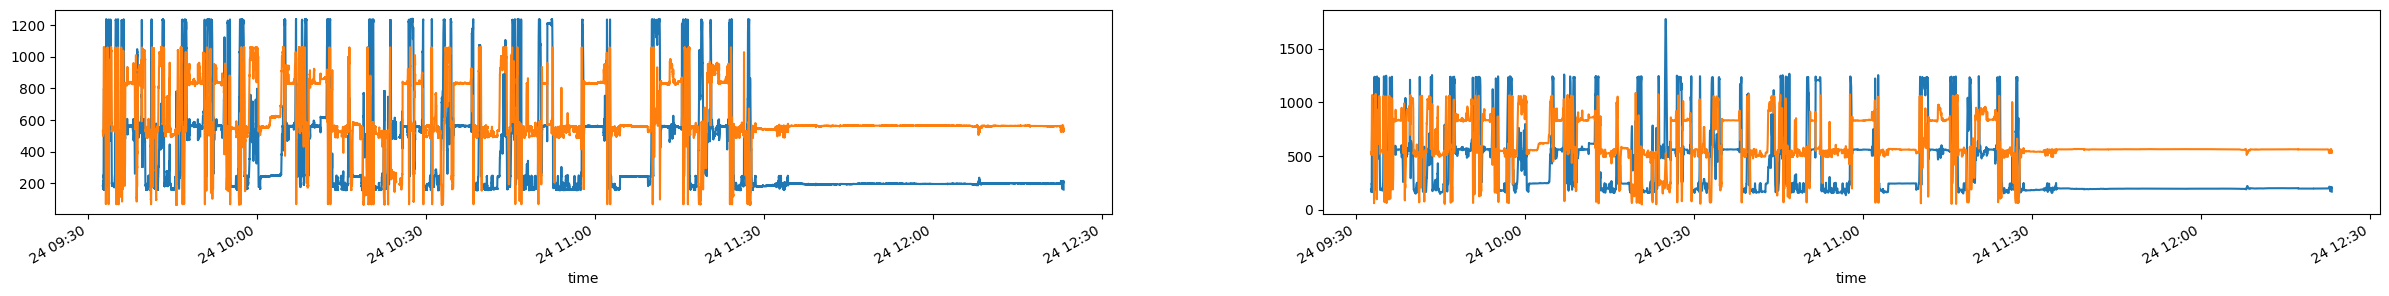

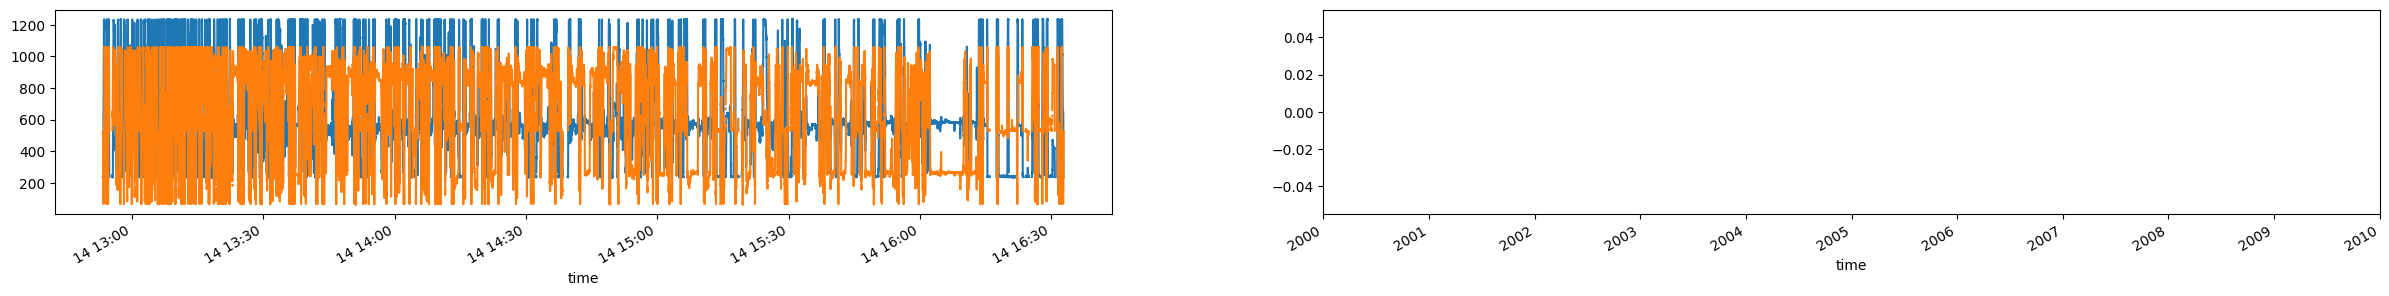

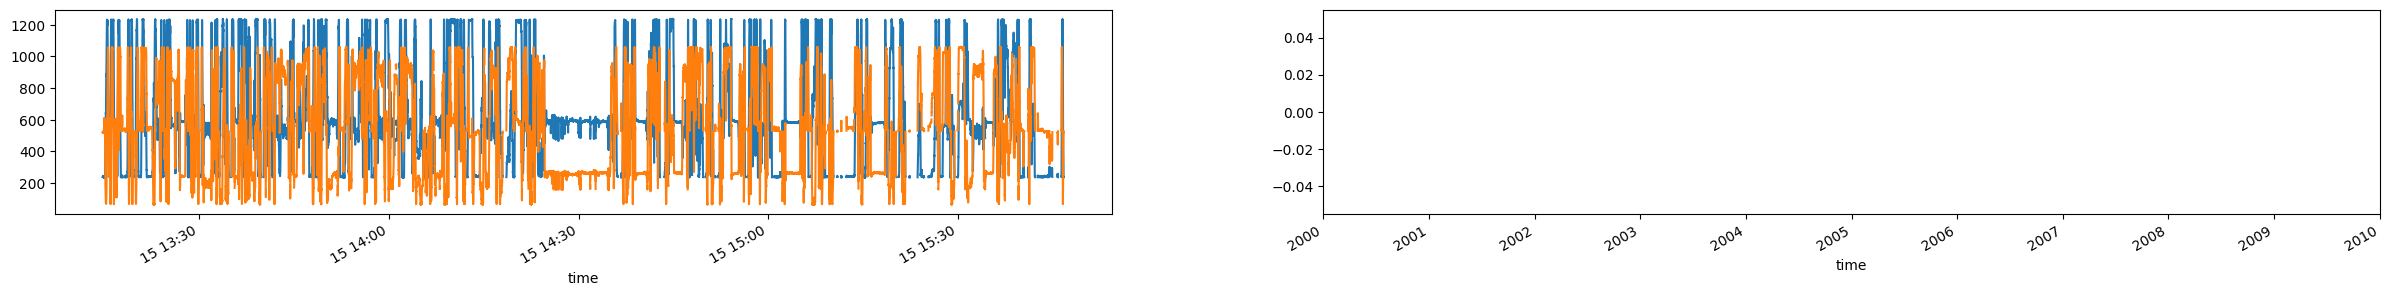

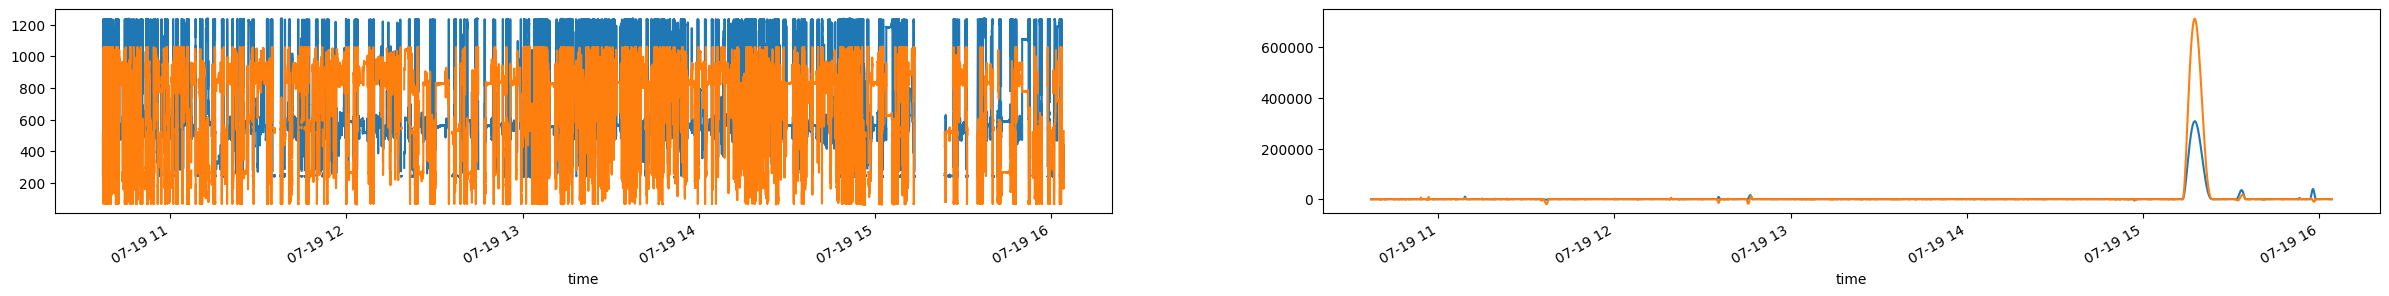

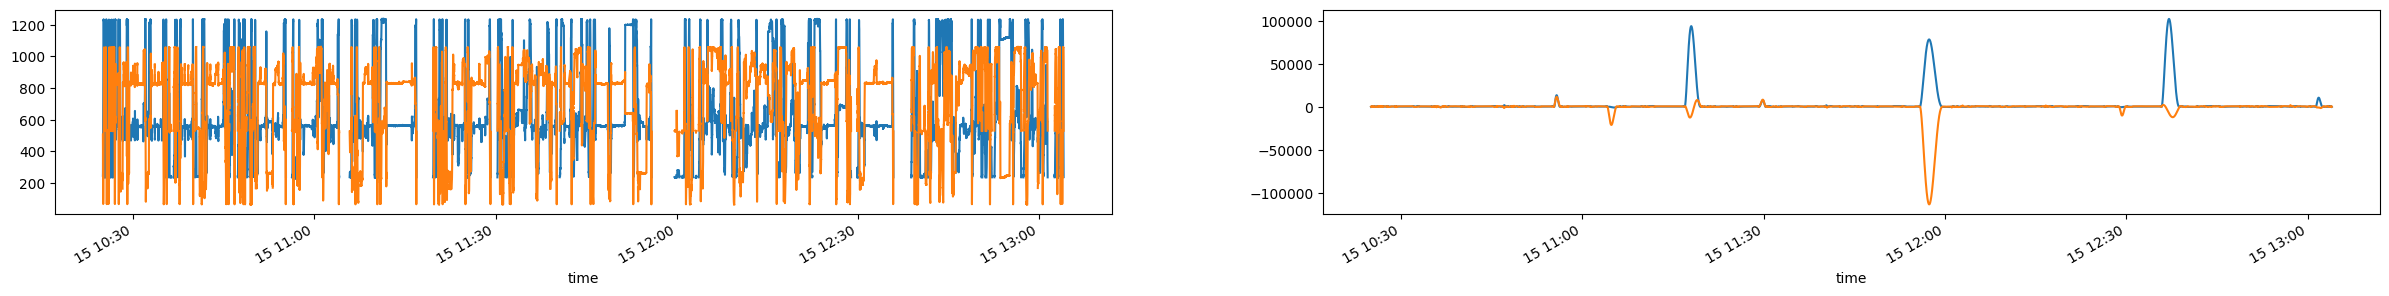

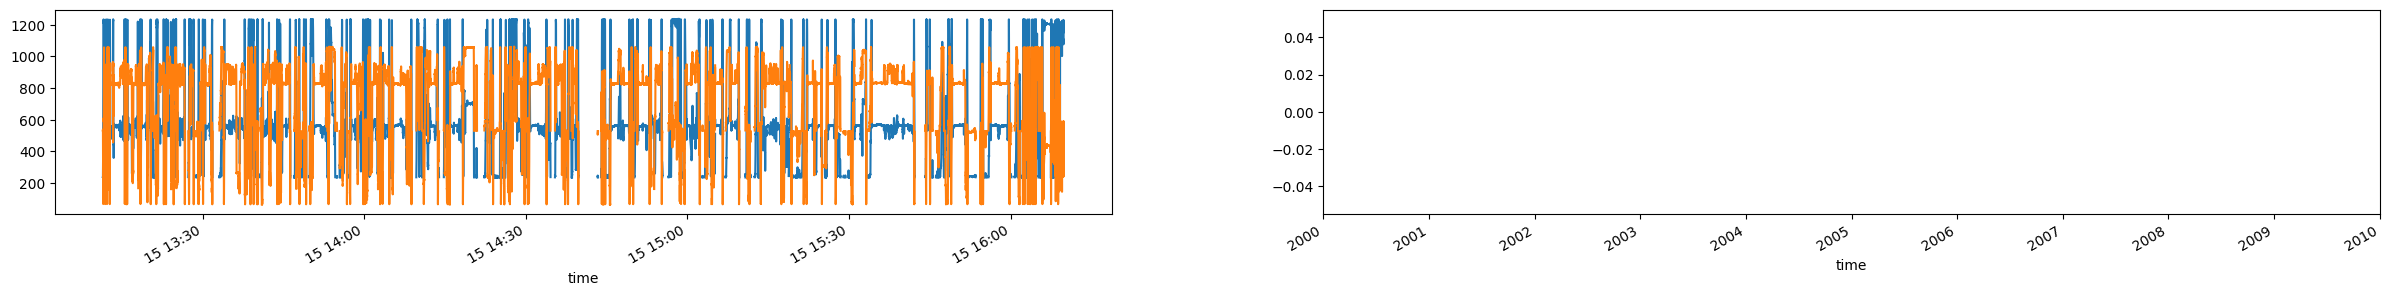

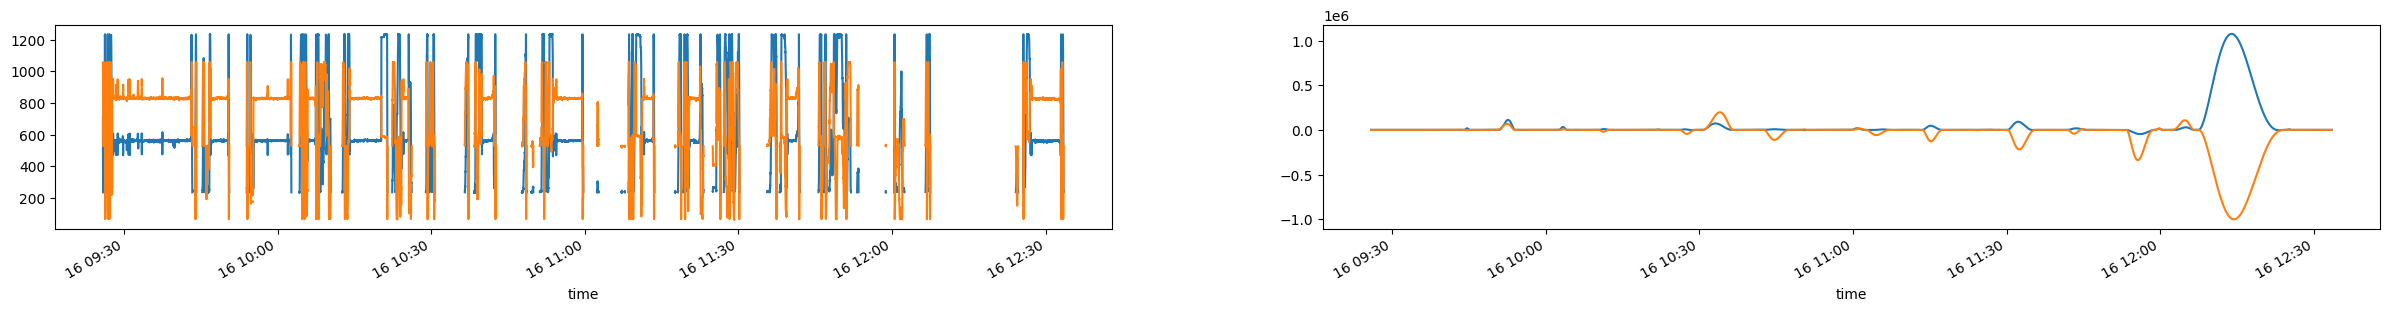

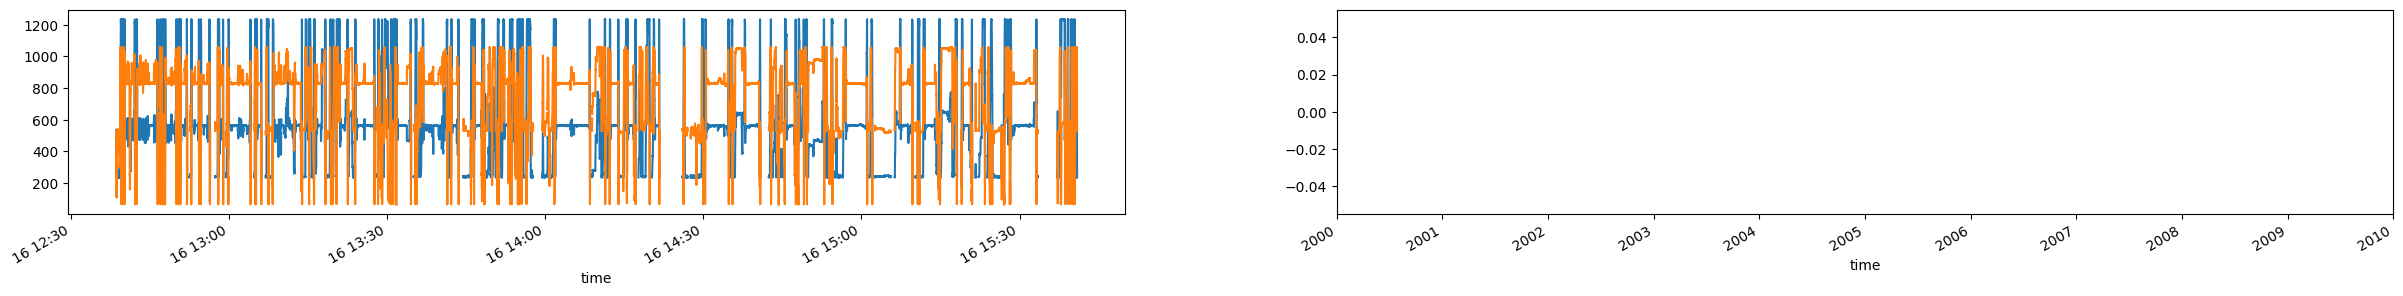

In [20]:
for session, i  in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    filterRes, smoothRes = FILTERRES_Short[i], SMOOTHRES_Short[i]
    
    start, end = session.enter, session.exit
    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
    
    len_df = len(mouse_pos)

    mouse_pos['smoothed_position_x'] = pd.Series(Extend(len_df, smoothRes['xnN'][0][0]), index=mouse_pos.index)
    mouse_pos['smoothed_position_y'] = pd.Series(Extend(len_df, smoothRes['xnN'][3][0]), index=mouse_pos.index)
    mouse_pos['smoothed_velocity_x'] = pd.Series(Extend(len_df, smoothRes['xnN'][1][0]), index=mouse_pos.index)
    mouse_pos['smoothed_velocity_y'] = pd.Series(Extend(len_df, smoothRes['xnN'][4][0]), index=mouse_pos.index)
    mouse_pos['smoothed_acce_x'] = pd.Series(Extend(len_df, smoothRes['xnN'][2][0]), index=mouse_pos.index)
    mouse_pos['smoothed_acce_y'] = pd.Series(Extend(len_df, smoothRes['xnN'][5][0]), index=mouse_pos.index)

    fig, axs = plt.subplots(1,2, figsize = (30,3))
    mouse_pos.x.plot(ax = axs[0])
    mouse_pos.y.plot(ax = axs[0])
    mouse_pos.smoothed_position_x.plot(ax = axs[1])
    mouse_pos.smoothed_position_y.plot(ax = axs[1])
    plt.show()

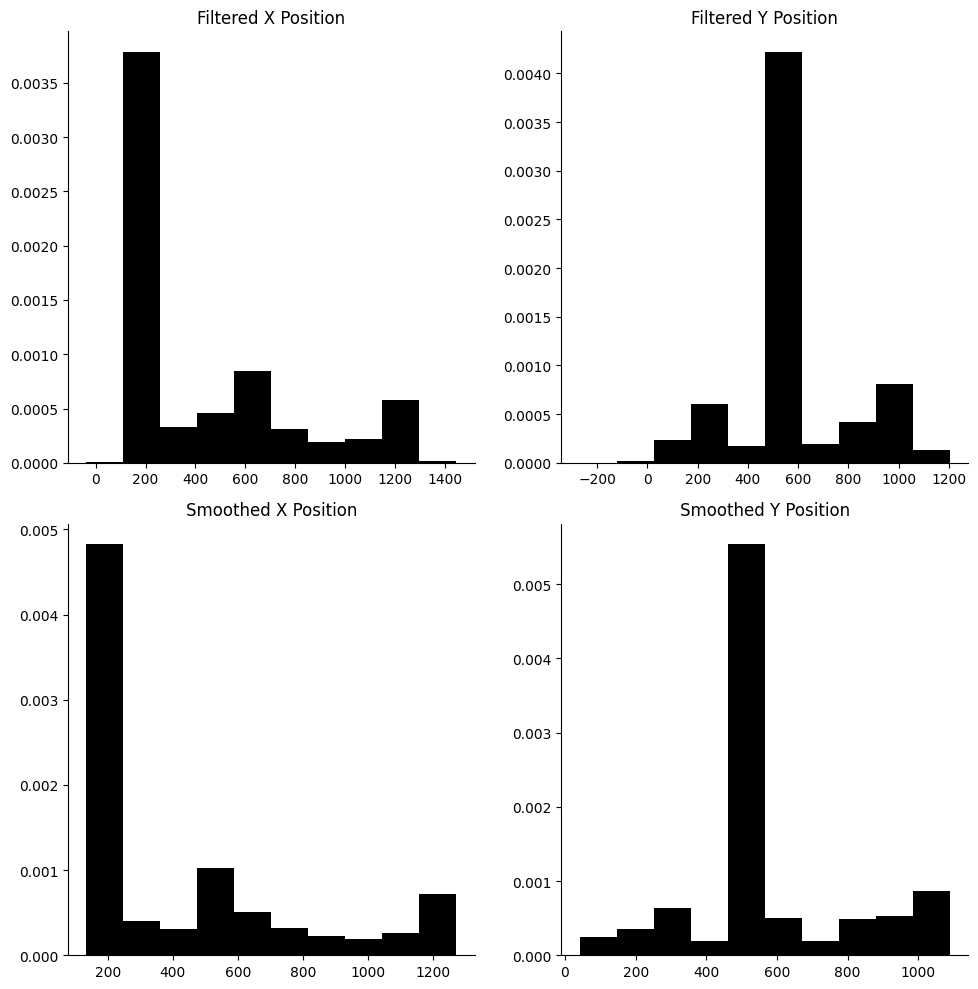

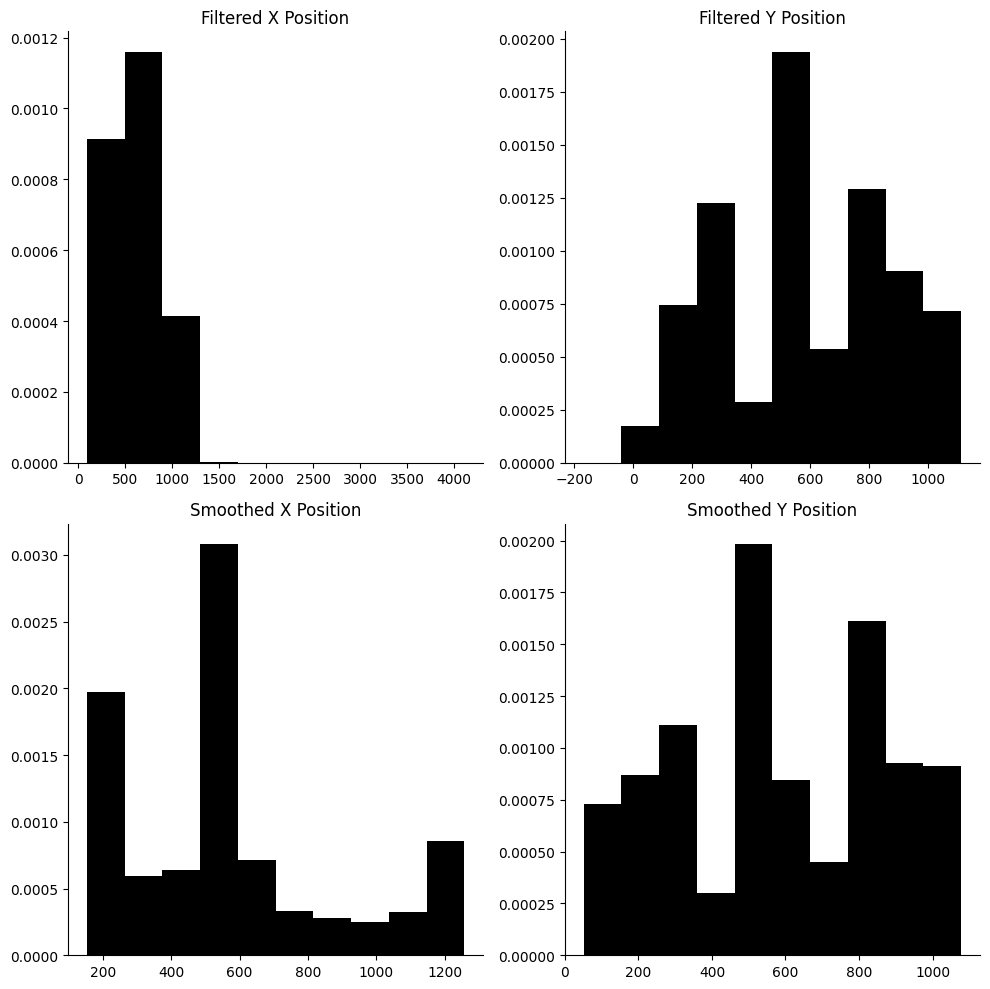

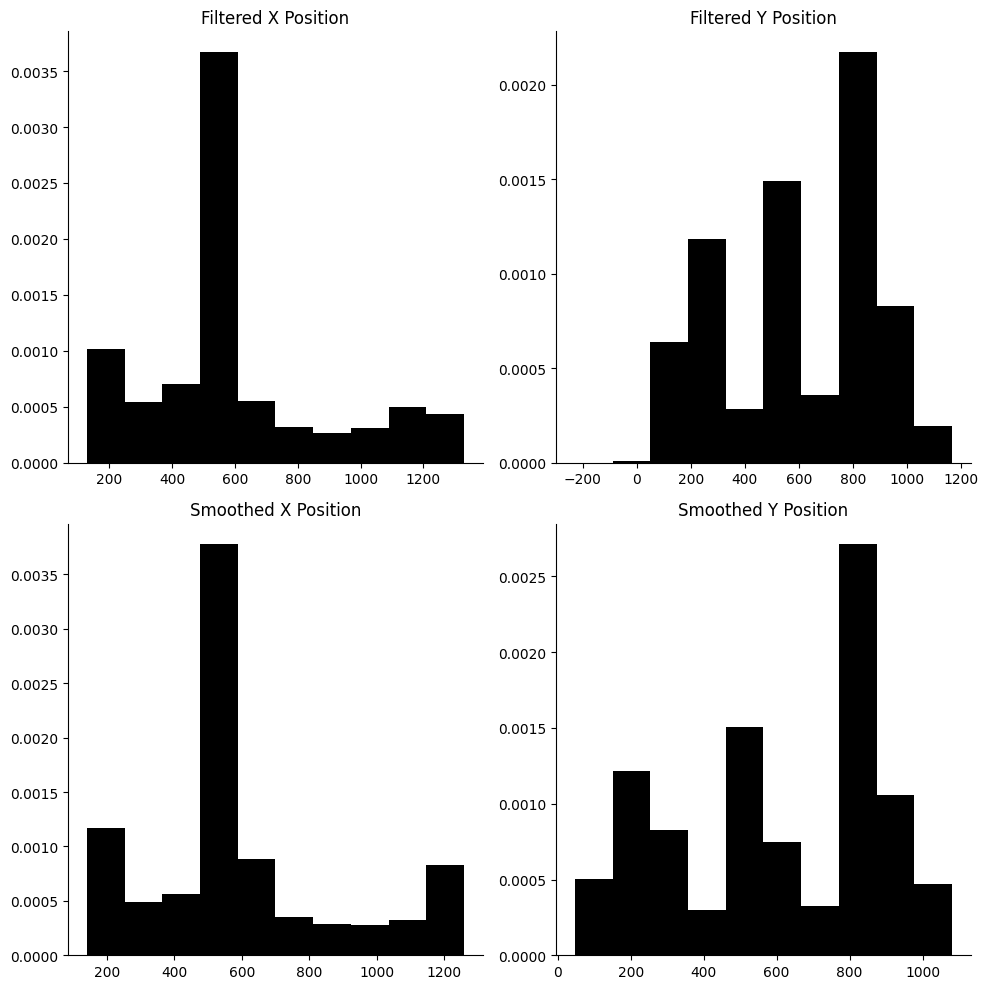

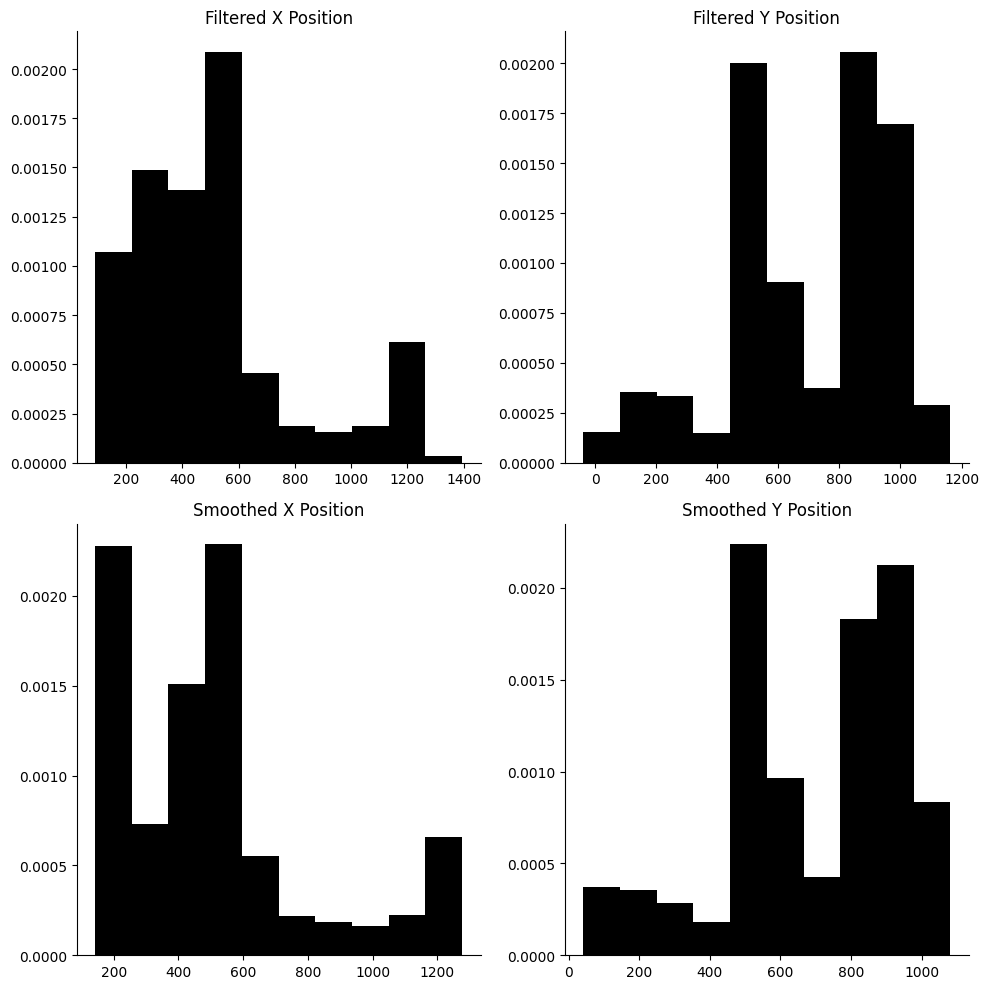

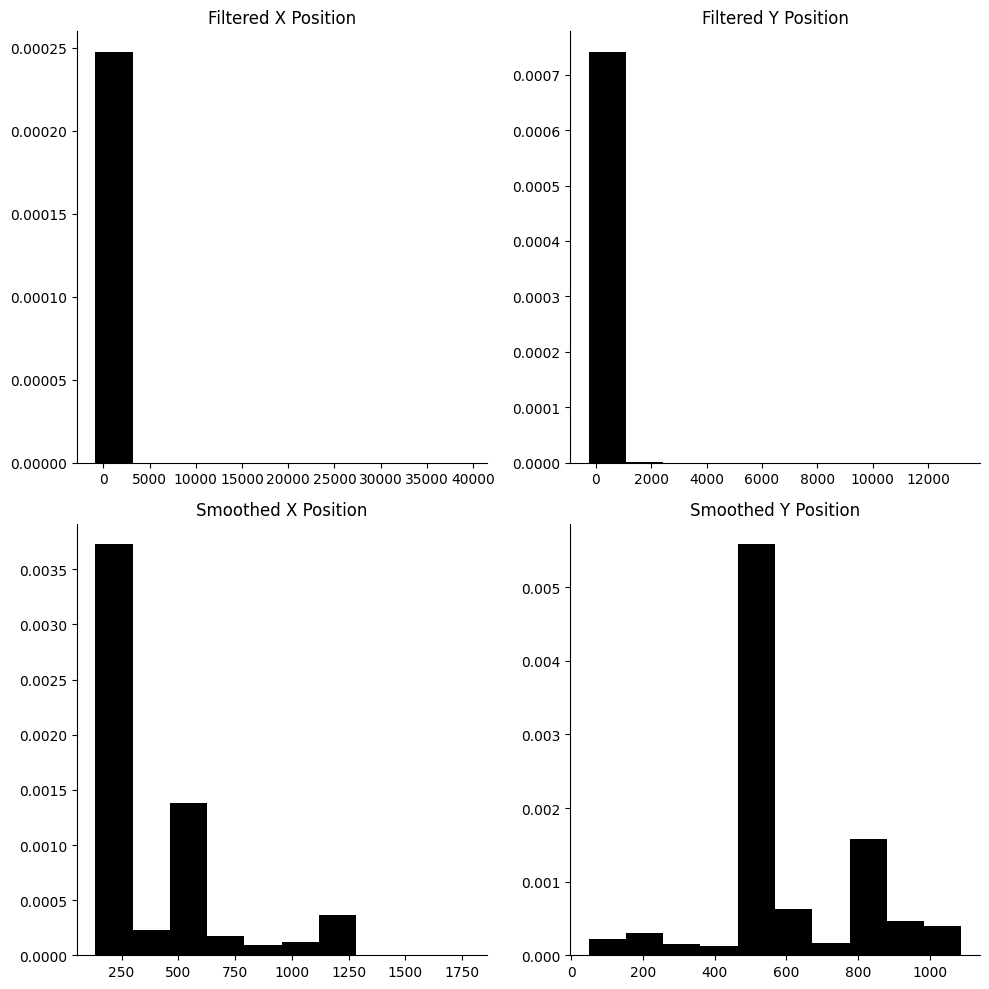

/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6826: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/nfs/nhome/live/zimol/.local/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6827: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

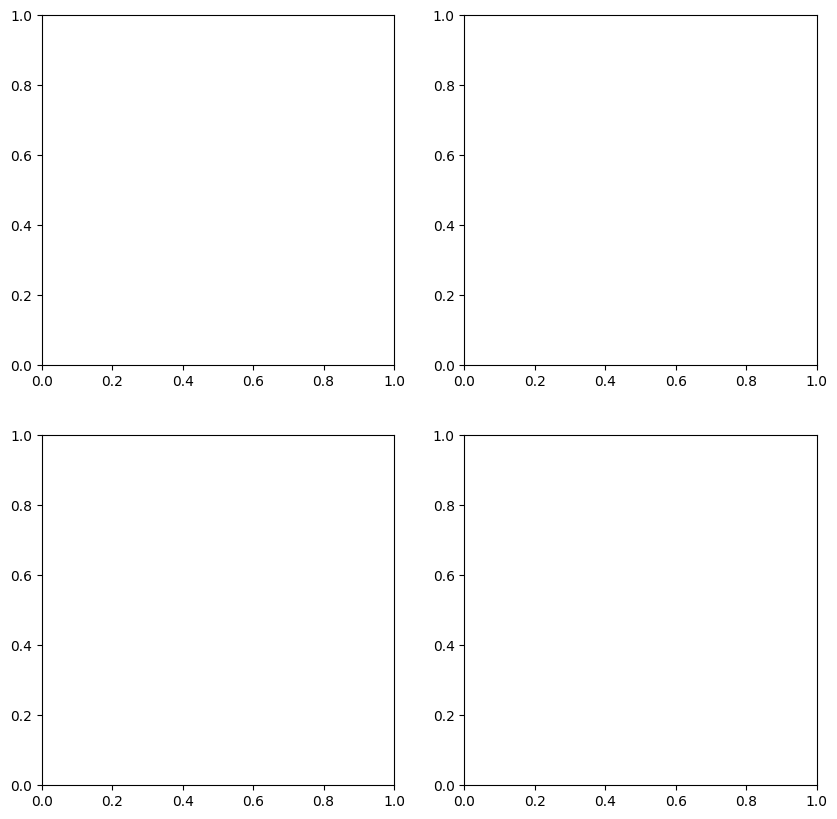

In [28]:
for i in range(len(FILTERRES_Short)):
    filterRes, smoothRes = FILTERRES_Short[i], SMOOTHRES_Short[i]
    
    fig, axs = plt.subplots(2,2, figsize = (10,10))
    axs[0,0].hist(filterRes['xnn'][0][0], color = 'black', density = True)
    axs[0,0].set_title("Filtered X Position")
    
    axs[0,1].hist(filterRes['xnn'][3][0], color = 'black', density = True)
    axs[0,1].set_title("Filtered Y Position")
    
    axs[1,0].hist(smoothRes['xnN'][0][0], color = 'black', density = True)
    axs[1,0].set_title("Smoothed X Position")
    
    axs[1,1].hist(smoothRes['xnN'][3][0], color = 'black', density = True)
    axs[1,1].set_title("Smoothed Y Position")
    
    for j in range(2):
        for k in range(2):
            axs[j,k].spines['top'].set_visible(False)
            axs[j,k].spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

## Velocity

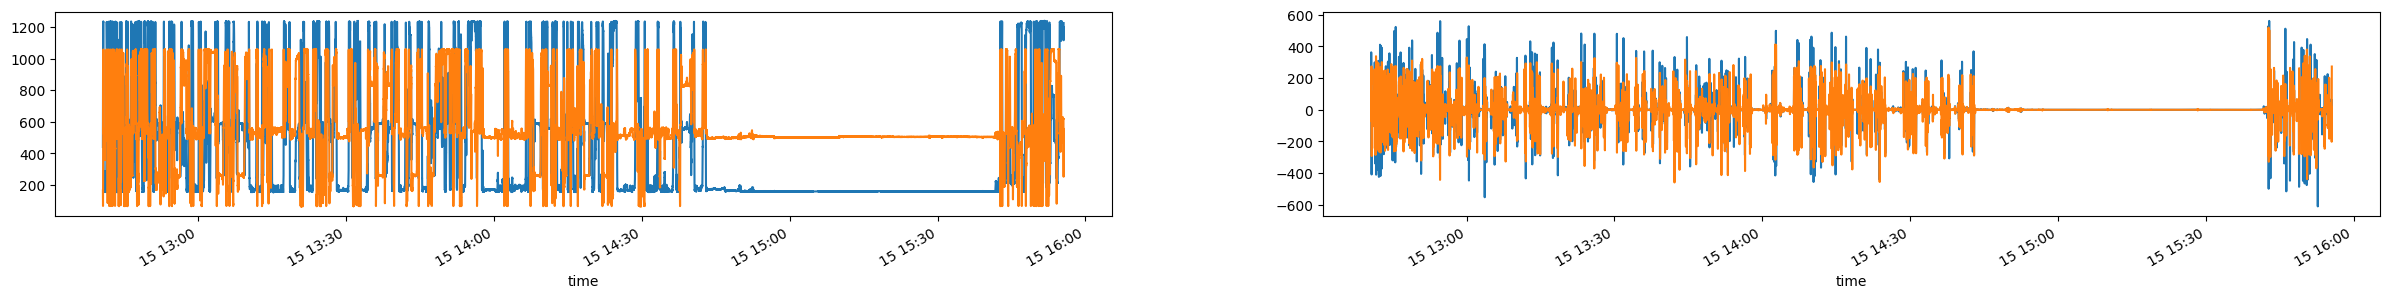

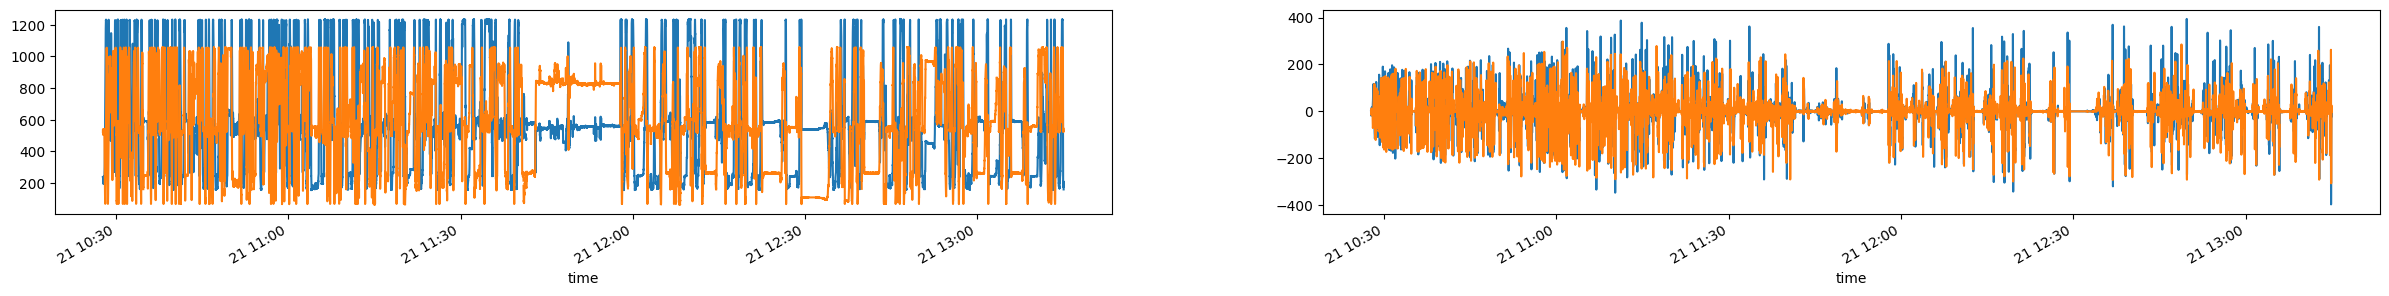

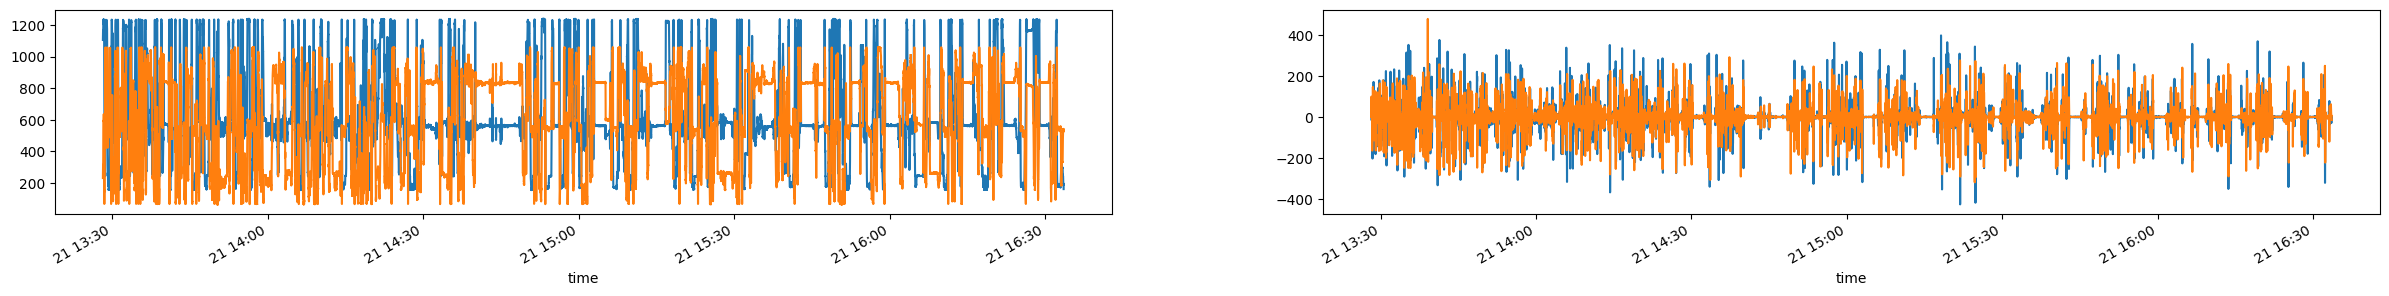

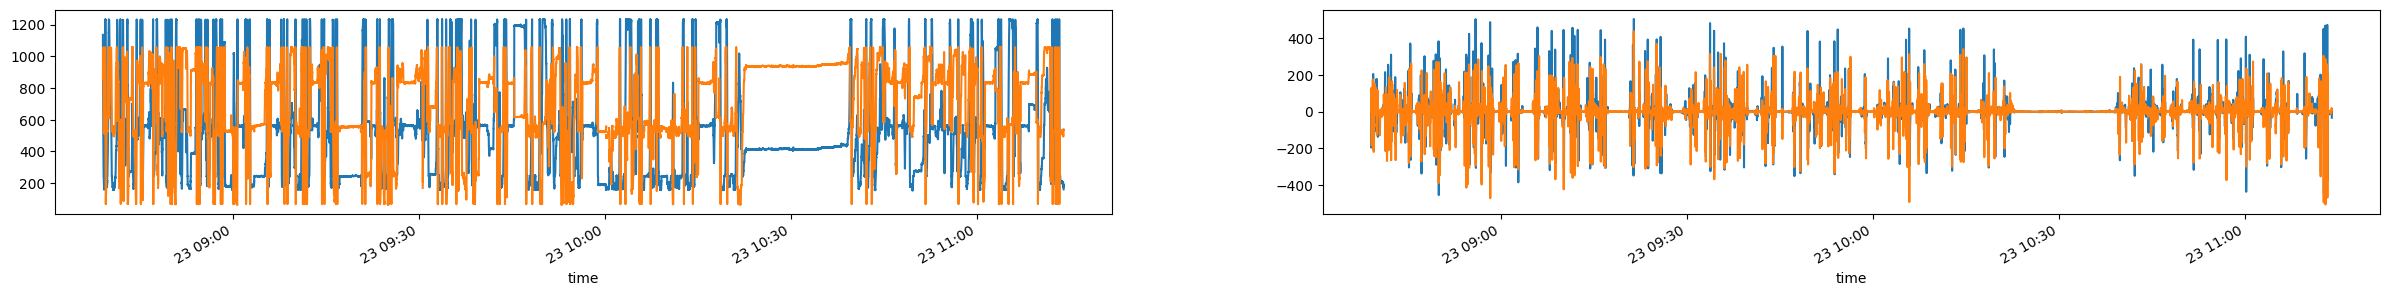

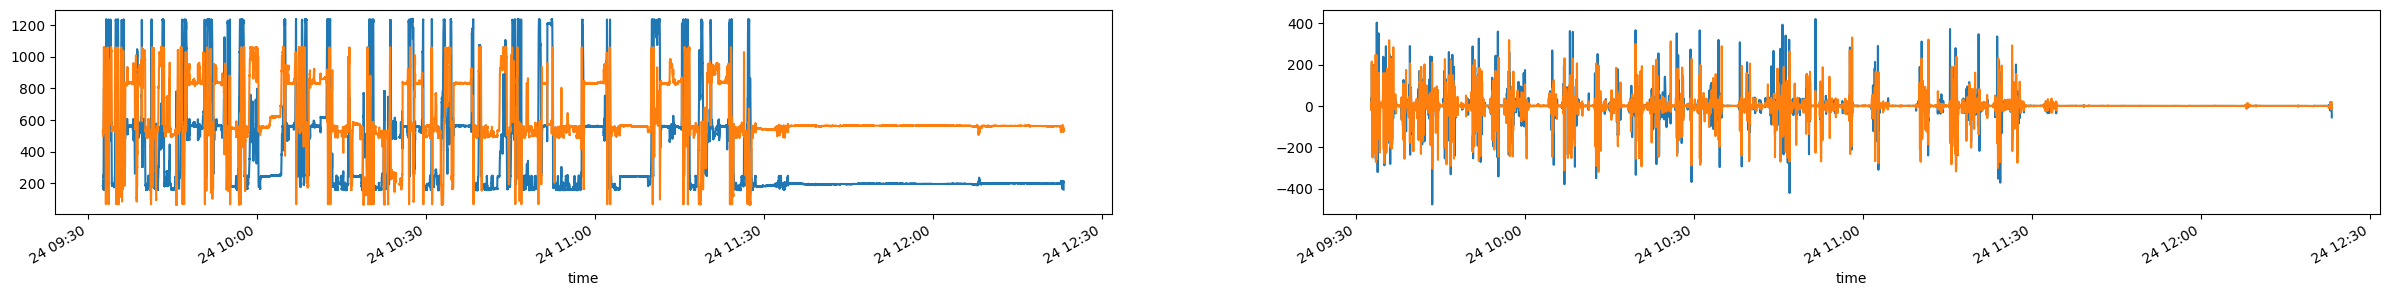

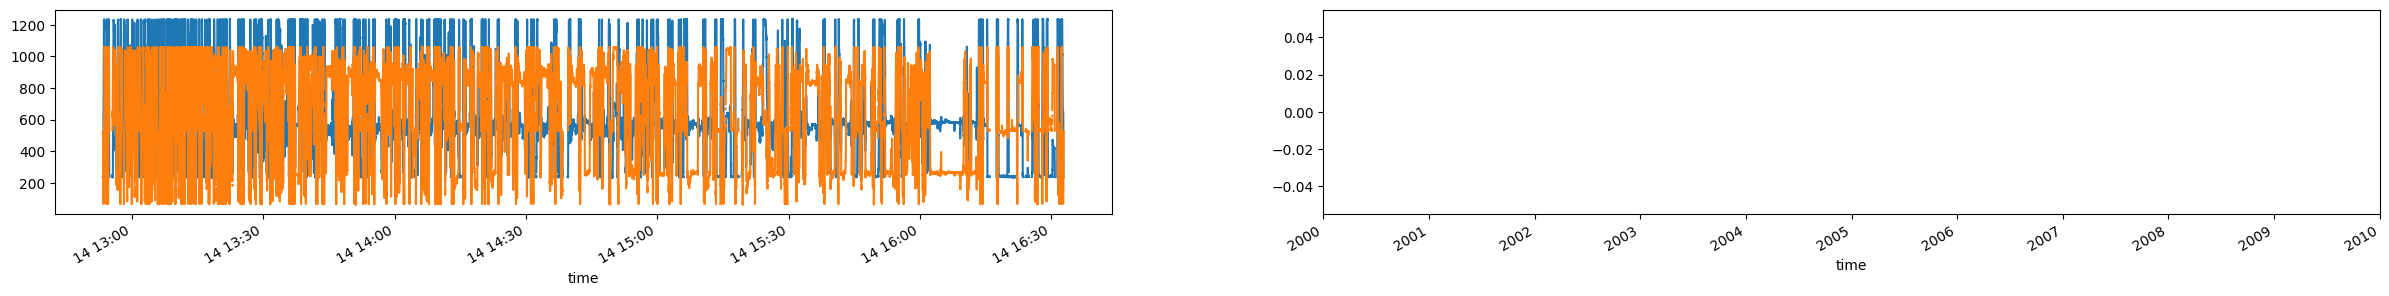

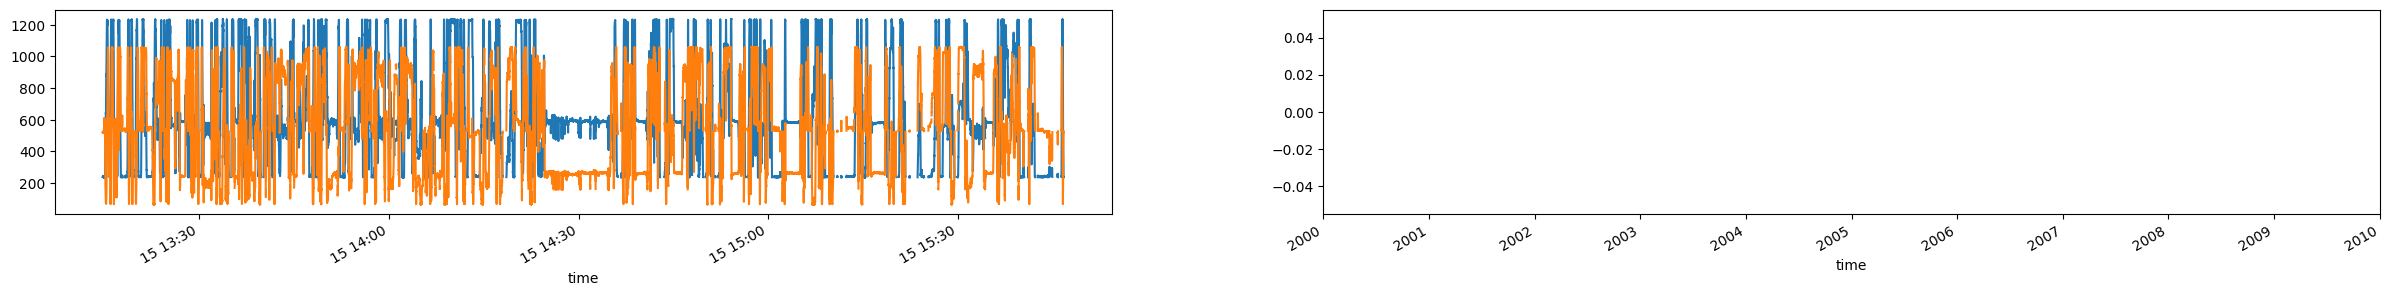

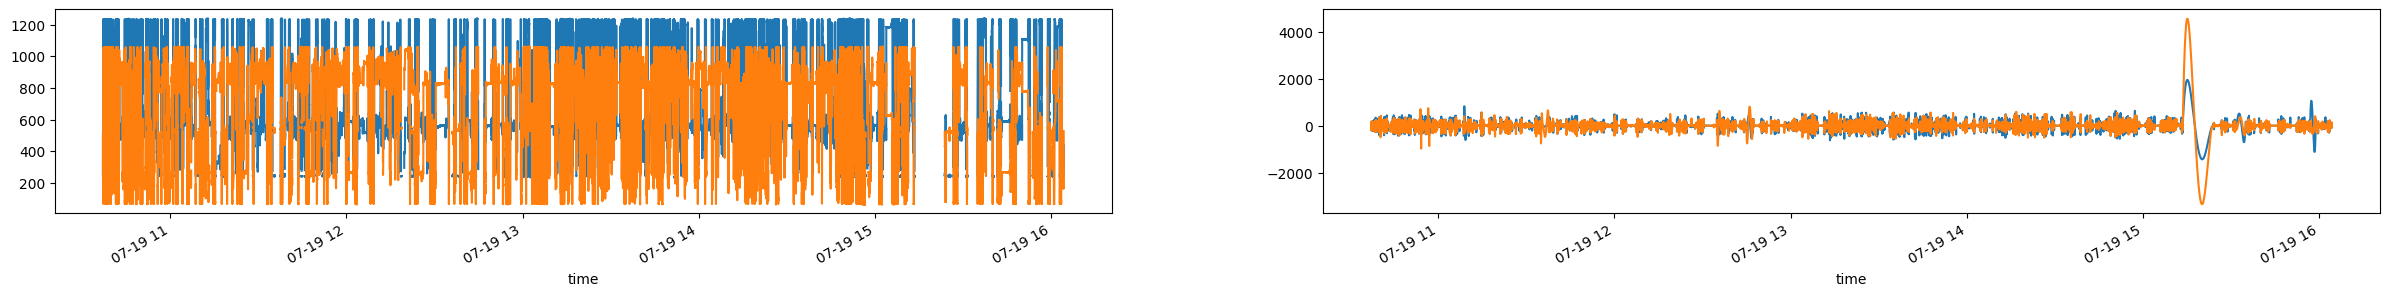

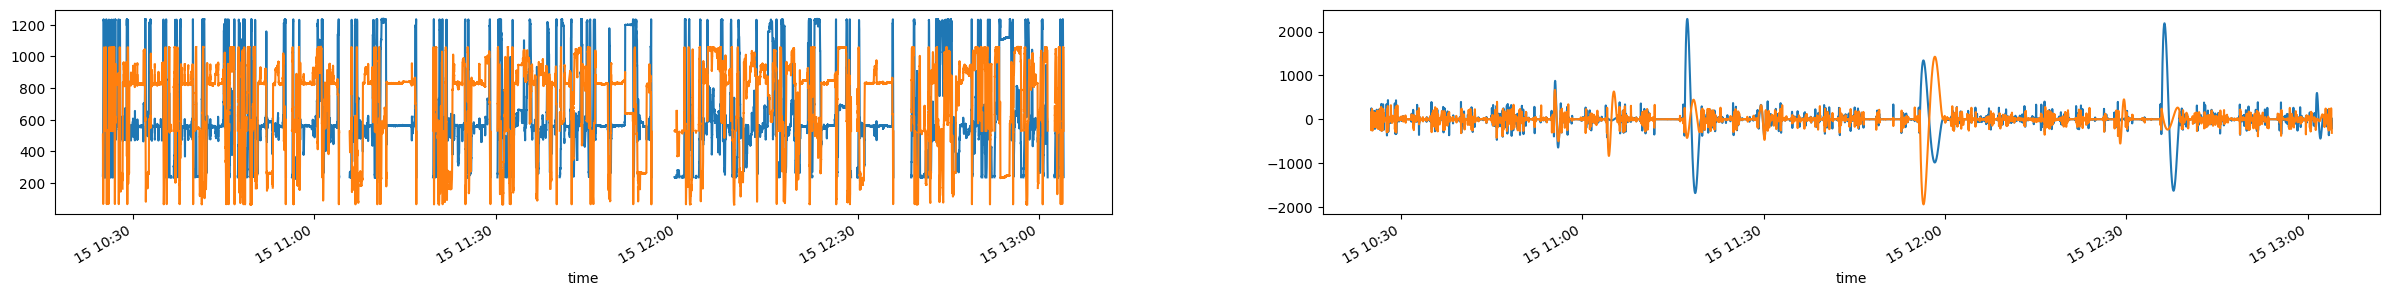

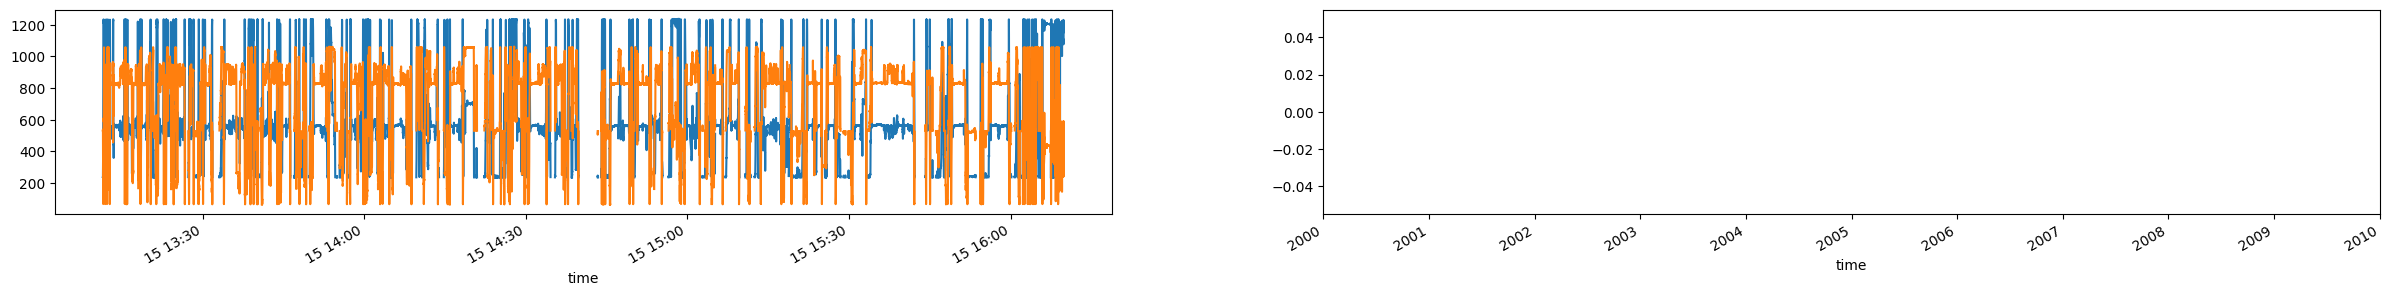

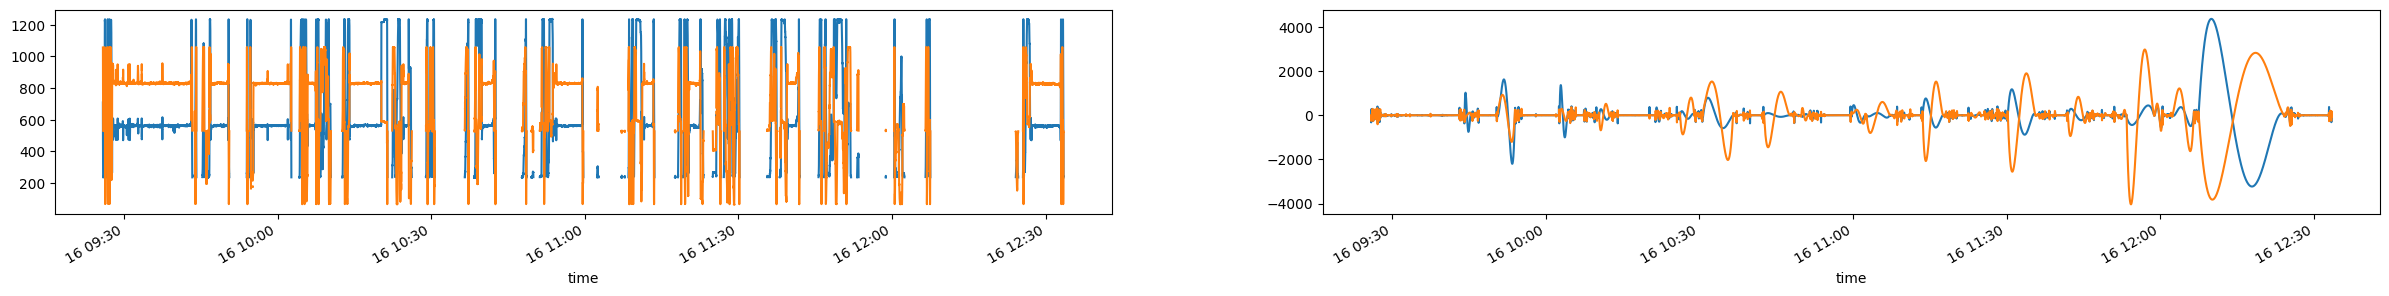

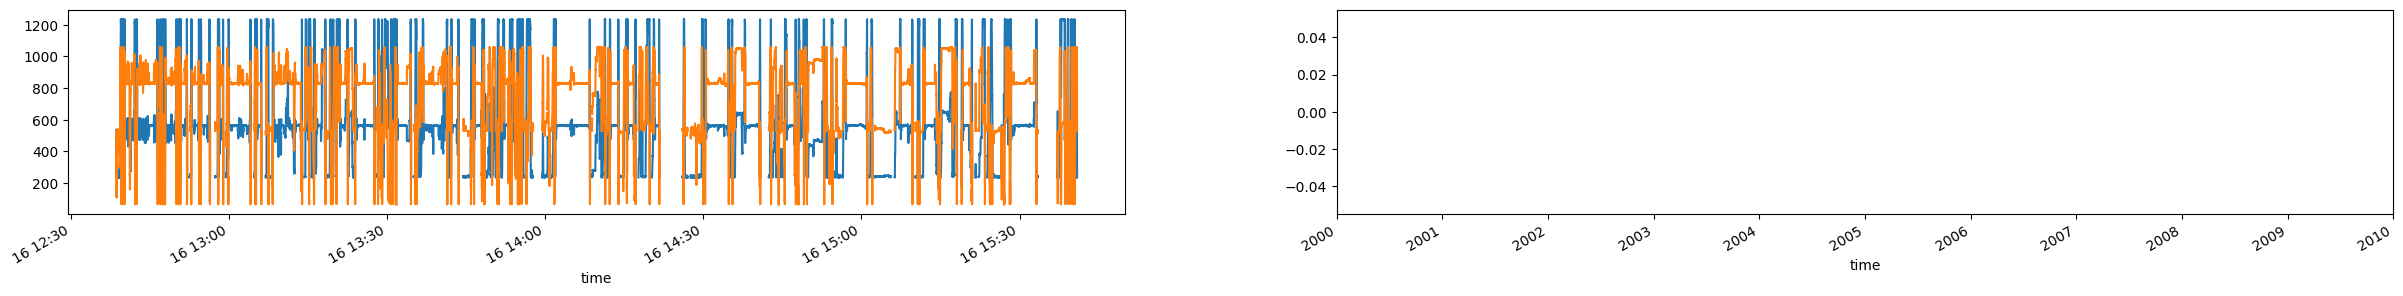

In [21]:
for session, i  in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    filterRes, smoothRes = FILTERRES_Short[i], SMOOTHRES_Short[i]
    
    start, end = session.enter, session.exit
    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)

    len_df = len(mouse_pos)

    mouse_pos['smoothed_velocity_x'] = pd.Series(Extend(len_df, smoothRes['xnN'][1][0]), index=mouse_pos.index)
    mouse_pos['smoothed_velocity_y'] = pd.Series(Extend(len_df, smoothRes['xnN'][4][0]), index=mouse_pos.index)

    fig, axs = plt.subplots(1,2, figsize = (30,3))
    mouse_pos.x.plot(ax = axs[0])
    mouse_pos.y.plot(ax = axs[0])
    mouse_pos.smoothed_velocity_x.plot(ax = axs[1])
    mouse_pos.smoothed_velocity_y.plot(ax = axs[1])
    plt.show()

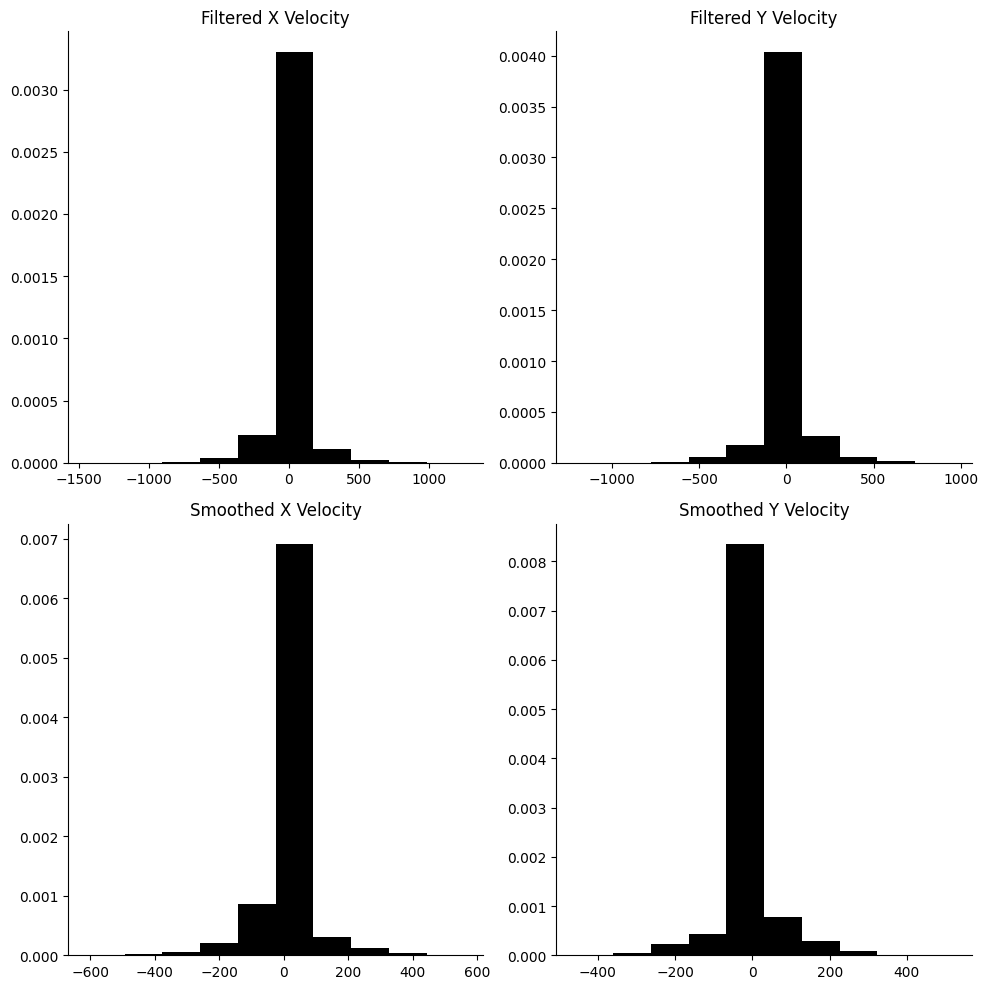

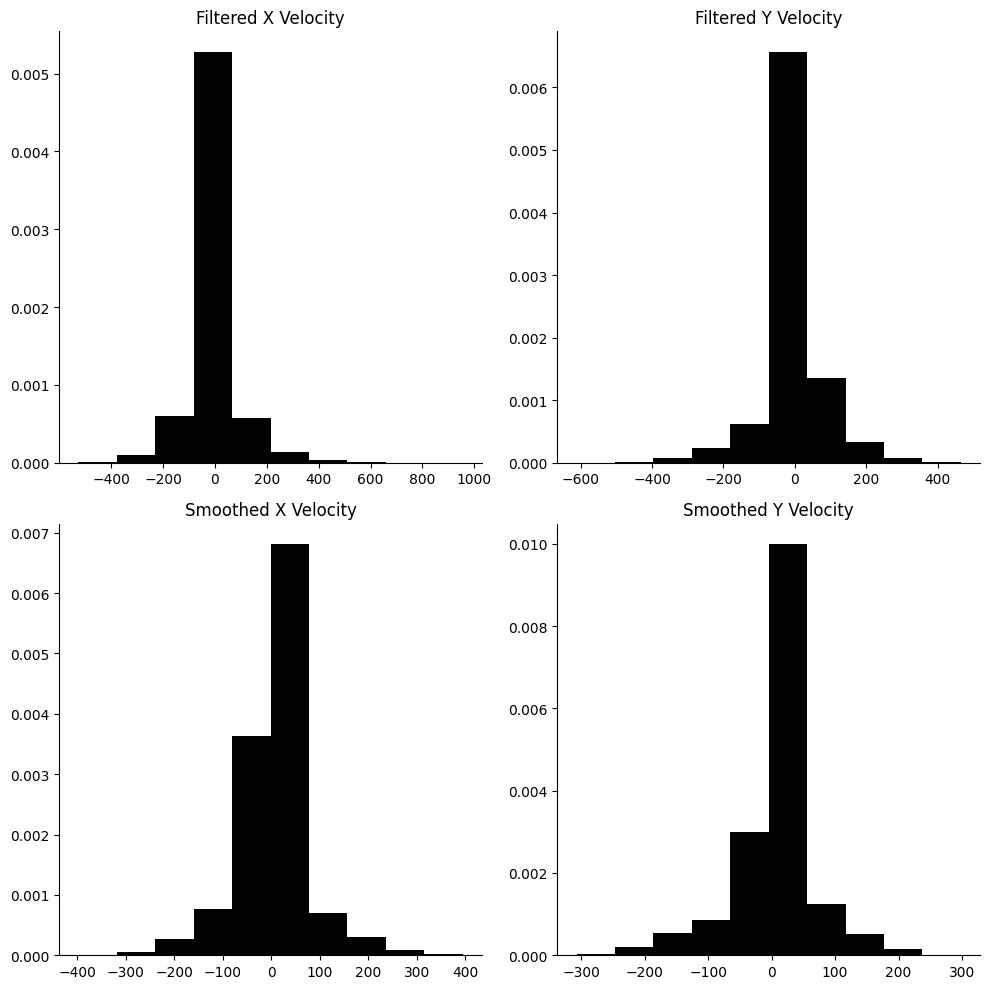

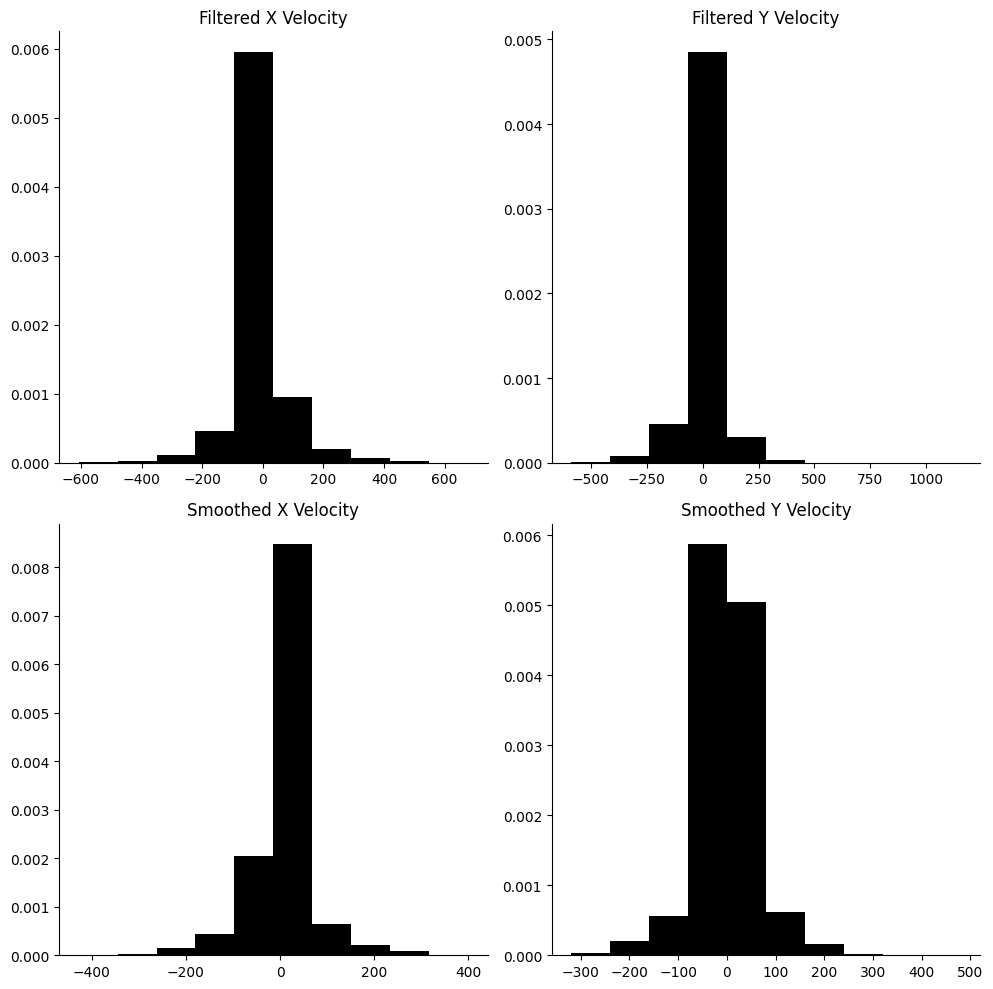

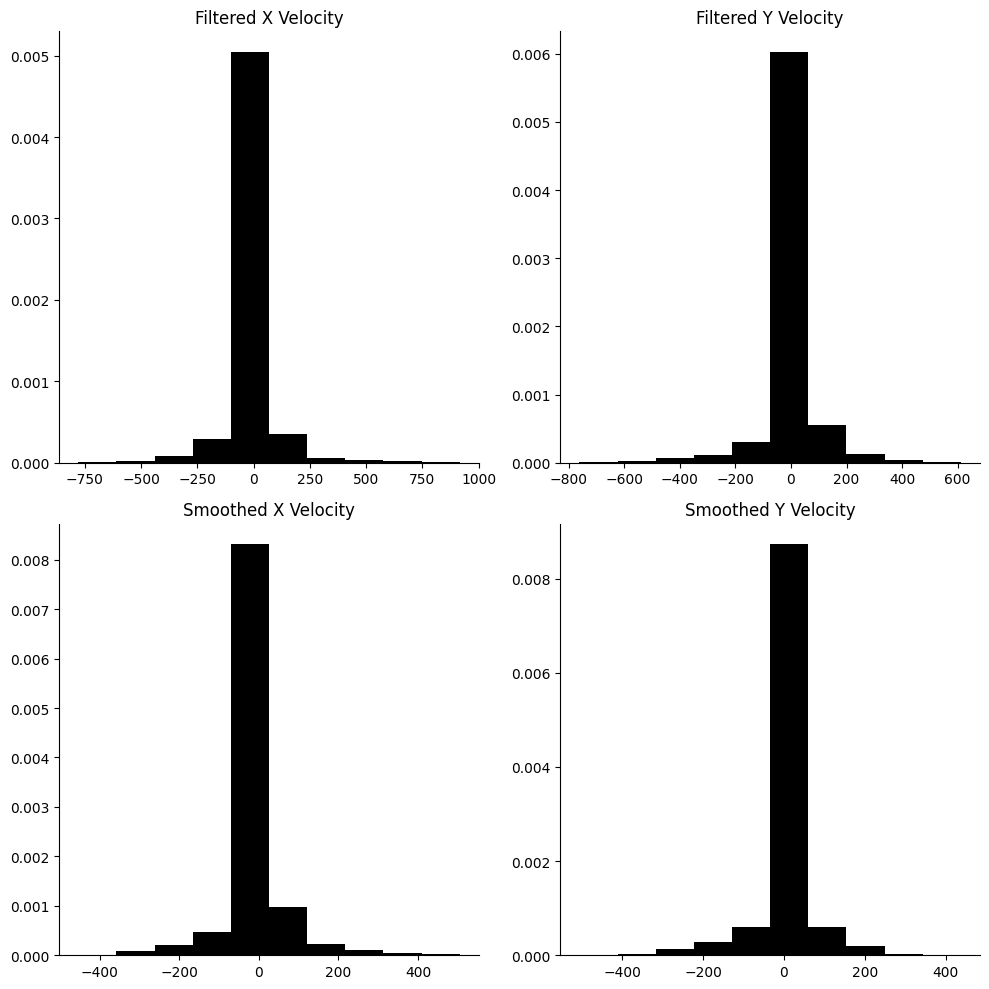

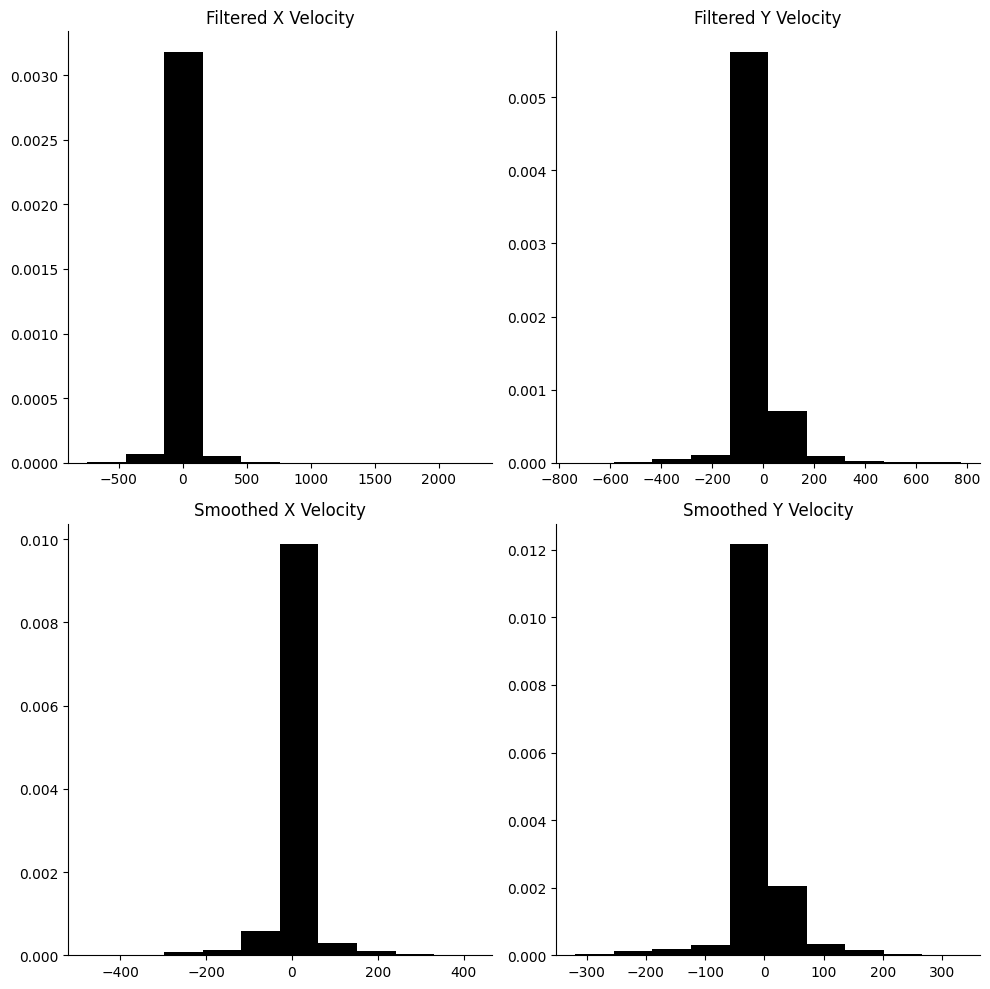

ValueError: autodetected range of [nan, nan] is not finite

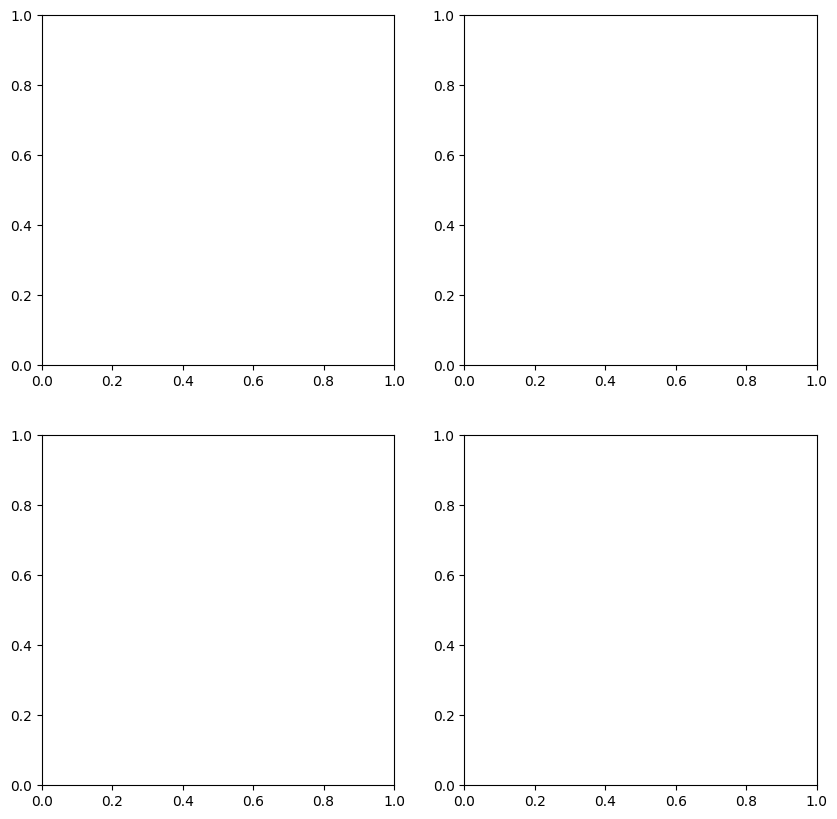

In [29]:
for i in range(len(FILTERRES_Short)):
    filterRes, smoothRes = FILTERRES_Short[i], SMOOTHRES_Short[i]
    
    fig, axs = plt.subplots(2,2, figsize = (10,10))
    axs[0,0].hist(filterRes['xnn'][1][0], color = 'black', density = True)
    axs[0,0].set_title("Filtered X Velocity")
    
    axs[0,1].hist(filterRes['xnn'][4][0], color = 'black', density = True)
    axs[0,1].set_title("Filtered Y Velocity")
    
    axs[1,0].hist(smoothRes['xnN'][1][0], color = 'black', density = True)
    axs[1,0].set_title("Smoothed X Velocity")
    
    axs[1,1].hist(smoothRes['xnN'][4][0], color = 'black', density = True)
    axs[1,1].set_title("Smoothed Y Velocity")
    
    for j in range(2):
        for k in range(2):
            axs[j,k].spines['top'].set_visible(False)
            axs[j,k].spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

## Acceleration Histogram